## Описание проекта

Нам предстоит работать с псевдо-реальными (реальные данные в которые добавлена синтетическая составляющая) данными о стартапах, функционировавших в период с 1970 по 2018 годы, и предсказать, какие из них закроются.


Описание полей данных
- `name` - Название стартапа
- `category_list` - Список категорий, к которым относится стартап
- `funding_total_usd` - Общая сумма финансирования в USD
- `status` - Статус стартапа (закрыт или действующий), **целевой признак**
- `country_code` - Код страны
- `state_code` - Код штата
- `region` - Регион
- `city` - Город
- `funding_rounds` - Количество раундов финансирования
- `founded_at` - Дата основания
- `first_funding_at` - Дата первого раунда финансирования
- `last_funding_at` - Дата последнего раунда финансирования
- `closed_at` - Дата закрытия стартапа (если применимо)
- `lifetime` - Время существования стартапа в днях

In [686]:
# imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
# from ydata_profiling import ProfileReport

import phik
import shap

# Импорт для разбивки и кодирования данных
from sklearn.impute import SimpleImputer
from sklearn.model_selection import (
    # Разбиение данных
    train_test_split,

    # Случайный поиск
    RandomizedSearchCV
)
from sklearn.preprocessing import (
    # Кодирование числовых значений
    StandardScaler,
    MinMaxScaler,
    RobustScaler,

    # Кодирование категориальных значение
    OneHotEncoder,
    LabelEncoder,
)

# Импорт для создания пайплайна
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Импорт моделей классификации
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from catboost import CatBoostClassifier
from xgboost import XGBClassifier

# Импорт метрик
from sklearn.metrics import (
    f1_score,
    precision_score,
    recall_score,
    confusion_matrix,
)

# Импорт для кросс-валидации
from optuna.integration import OptunaSearchCV
from optuna import distributions

RANDOM_STATE = 42

 ## Загрузка и проверка данных

In [687]:

    # Импортируем тренировочный датасет
df = pd.read_csv('data/startup_train.csv',
                     parse_dates=['founded_at', 'first_funding_at', 'last_funding_at', 'closed_at'])

    # Импортируем тестовый датасет
test_df = pd.read_csv('data/startup_test.csv',
                          parse_dates=['first_funding_at', 'last_funding_at'])

In [688]:
# Выводим информацию о тренировочном датасете
print(df.info())
df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52516 entries, 0 to 52515
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   name               52515 non-null  object        
 1   category_list      50051 non-null  object        
 2   funding_total_usd  42447 non-null  float64       
 3   status             52516 non-null  object        
 4   country_code       47014 non-null  object        
 5   state_code         45753 non-null  object        
 6   region             46157 non-null  object        
 7   city               46157 non-null  object        
 8   funding_rounds     52516 non-null  int64         
 9   founded_at         52516 non-null  datetime64[ns]
 10  first_funding_at   52516 non-null  datetime64[ns]
 11  last_funding_at    52516 non-null  datetime64[ns]
 12  closed_at          4917 non-null   datetime64[ns]
dtypes: datetime64[ns](4), float64(1), int64(1), object(7)
memory 

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at
0,Lunchgate,Online Reservations|Restaurants,828626.0,operating,CHE,25,Zurich,Zürich,2,2009-10-17,2011-05-01,2014-12-01,NaT
1,EarLens,Manufacturing|Medical|Medical Devices,42935019.0,operating,USA,CA,SF Bay Area,Redwood City,4,2005-01-01,2010-05-04,2014-02-25,NaT
2,Reviva Pharmaceuticals,Biotechnology,35456381.0,operating,USA,CA,SF Bay Area,San Jose,3,2006-01-01,2012-08-20,2014-07-02,NaT
3,Sancilio and Company,Health Care,22250000.0,operating,NaN,NaN,NaN,NaN,3,2004-01-01,2011-09-01,2014-07-18,NaT
4,WireTough Cylinders,Manufacturing,NaN,operating,USA,VA,VA - Other,Bristol,1,2010-05-12,2012-02-01,2012-02-01,NaT
...,...,...,...,...,...,...,...,...,...,...,...,...,...
52511,Videostream,Entertainment,NaN,operating,CAN,ON,Toronto,Kitchener,1,2012-01-01,2014-03-01,2014-03-01,NaT
52512,Hello Curry,Hospitality,500000.0,operating,IND,2,Hyderabad,Hyderabad,1,2013-08-25,2014-03-07,2014-03-07,NaT
52513,Taskforce,Email|Messaging|Productivity Software,50000.0,operating,USA,CA,SF Bay Area,San Francisco,3,2010-07-01,2009-06-14,2011-01-01,NaT
52514,NetScaler,Security,13000000.0,operating,USA,CA,SF Bay Area,San Jose,6,1997-12-01,1998-11-30,2004-03-01,NaT


Мы видим, что большинство данных у нас приведены к корректному типу данных. Мы можем привести столбец `status` к булевому типу, так как он принимает всего 2 значения: closed и operating. Сделаем это позже, используя label encoder. У нас в тренировочных данных присутствует столбец `closed_at`. Удалим его, так как это будет являться утечкой целевого признака

In [689]:
# Выводим информацию о тестовом датасете
print(test_df.info())
test_df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13125 entries, 0 to 13124
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   name               13125 non-null  object        
 1   category_list      12534 non-null  object        
 2   funding_total_usd  10547 non-null  float64       
 3   country_code       11743 non-null  object        
 4   state_code         11430 non-null  object        
 5   region             11536 non-null  object        
 6   city               11538 non-null  object        
 7   funding_rounds     13125 non-null  int64         
 8   first_funding_at   13125 non-null  datetime64[ns]
 9   last_funding_at    13125 non-null  datetime64[ns]
 10  lifetime           13125 non-null  int64         
dtypes: datetime64[ns](2), float64(1), int64(2), object(6)
memory usage: 1.1+ MB
None


,name,category_list,funding_total_usd,country_code,state_code,region,city,funding_rounds,first_funding_at,last_funding_at,lifetime
0,Crystalsol,Clean Technology,2819200.0,NIC,17,NaN,NaN,1,2009-07-01,2009-07-01,3501
1,JBI Fish & Wings,Hospitality,NaN,USA,TN,TN - Other,Humboldt,1,2010-07-28,2010-07-28,2717
2,COINPLUS,Finance,428257.0,LUX,3,Esch-sur-alzette,Esch-sur-alzette,2,2014-05-15,2014-09-18,1295
3,Imagine Communications,Software|Video|Video Streaming,34700000.0,USA,CA,San Diego,San Diego,4,2005-01-01,2010-04-20,4748
4,DNA13,Software,4530000.0,CAN,ON,Ottawa,Ottawa,1,2007-05-08,2007-05-08,6209
...,...,...,...,...,...,...,...,...,...,...,...
13120,Jymob,Recruiting,28000.0,USA,CA,SF Bay Area,Sunnyvale,1,2012-07-01,2012-07-01,2267
13121,GlobaTrek,Software,NaN,USA,CA,SF Bay Area,Mountain View,1,2013-10-01,2013-10-01,2192
13122,Inkd.com,Design|E-Commerce|Marketplaces|Printing,5600000.0,USA,WA,Seattle,Seattle,3,2008-09-01,2011-06-28,2922
13123,AdWill,Advertising Exchanges|Mobile|Mobile Advertising,150000.0,USA,NY,New York City,New York,2,2014-09-27,2014-11-04,1386


В тестовом датасете данные все данные так же приведены к правильному типу данных. Столбец `lifetime` нам придется удалить, так как он не фигурирует в обучающих данных. Мы могли бы посчитать `lifetime` в тренировочной таблице, однако это будет утечкой целевого признака, так как для компаний, которые все еще не закрылись, данных не будет

### Вывод:

Мы видим, что большинство данных у нас приведены к корректному типу данных. Мы можем привести столбец `status` к булевому типу, так как он принимает всего 2 значения: closed и operating. Сделаем это позже, используя label encoder. У нас в тренировочных данных присутствует столбец `closed_at`. Удалим его, так как это будет являться утечкой целевого признака.

В тестовом датасете данные все данные так же приведены к правильному типу данных. Столбец `lifetime` нам придется удалить, так как он не фигурирует в обучающих данных. Мы могли бы посчитать `lifetime` в тренировочной таблице, однако это будет утечкой целевого признака, так как для компаний, которые все еще не закрылись, данных не будет


## Предобработка данных:

Посмотрим на наличие выбросов и пропусков. Обработаем их, если возможно

In [690]:
# Объявим список числовых, категориальных, и столбцов с датой
num_col_names = ['funding_total_usd', 'funding_rounds']
cat_col_names = ['category_list', 'country_code', 'state_code', 'region', 'city']
date_col_names = ['founded_at', 'first_funding_at', 'last_funding_at', 'closed_at']

### Предобработка данных в тренировочном датасете

In [691]:
# Выводим информацию о пропусках и уникальных значениях
pd.DataFrame({
    'missing_count': df.isna().sum(),
    'missing_percent': round(df.isna().sum() / df.shape[0] * 100, 1),

    'unique_count': df.nunique(),
    'unique_percent': round(df.nunique() / df.shape[0] * 100, 1),
})

,missing_count,missing_percent,unique_count,unique_percent
name,1,0.0,52515,100.0
category_list,2465,4.7,22105,42.1
funding_total_usd,10069,19.2,15551,29.6
status,0,0.0,2,0.0
country_code,5502,10.5,134,0.3
state_code,6763,12.9,300,0.6
region,6359,12.1,1036,2.0
city,6359,12.1,4477,8.5
funding_rounds,0,0.0,19,0.0
founded_at,0,0.0,5402,10.3


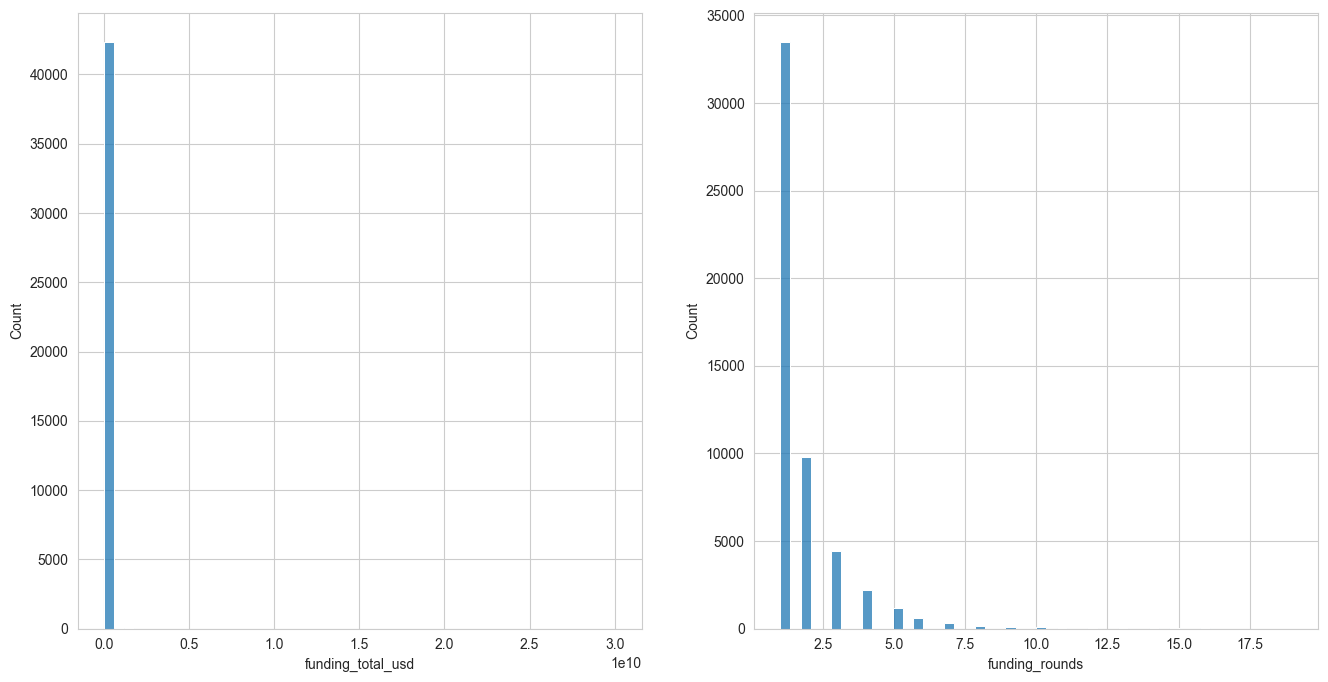

In [692]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))

# Выводим гистограмму числовых значений
for i in range(len(num_col_names)):
    sns.histplot(data=df, x=num_col_names[i], bins=50, ax=axes[i])

plt.show()

Рассмотрим столбцы, которые у нас есть
- `name` — в данном столбце у нас всего один пропуск, но эта это никак не повлияет на обучение модели, оставим все как есть
- `category_list` — в данном столбце у нас отсутствует 4.7% данных. Всего там 44% уникальных значений. Скорее всего пропуски в данном столбце мы заполним модой
- `funding_total_usd` — в данном столбце у нас отсутствует 19.2% данных. Так же по гистограмме видно, что там присутствуют выбросы. Рассмотрим это детальнее с помощью boxplot
- `status` — в данном столбце у нас представлен целевой признак. 90% компаний все еще работают, в то время как 10% компаний закрылись
- `country_code`— в данном столбце у нас отсутствует 10.5% данных. Всего там 134 уникальных значения. Пропуски мы заполним, медианным значением.
- `state_code`— в данном столбце у нас отсутствует 13% данных. Всего там 300 уникальных значений. Пропуски мы заполним медианным значением, предварительно сгруппировав данные по `county_code`
- `region`— в данном столбце у нас отсутствует 12% данных. Всего там 1036 уникальных значений. Пропуски мы заполним модой, сгруппировав `state_code`
- `city` — в данном столбце у нас отсутствует 12% данных. Всего там 4477 уникальных значений. Пропуски мы заполним модой, сгруппировав `city`
- `funding_rounds`— в данном столбце у нас нет пропусков, однако присутствуют выбросы. Рассмотрим это детальнее с помощью boxplot
- `founded_at` — в данном столбце у нас нет пропусков и выбросов. Гистограмма выглядит так, потому что в ранние годы либо было сильно меньше стартапов, либо их регистрация не фиксировалась
- `first_funding_at` — в данном столбце у нас аналогично предыдущему
- `last_funding_at` — в данном столбце у нас все аналогично предыдущему
- `closed_at` — в данном столбце у нас отсутствует 90% данных, но этот столбец понадобится нам только для исследовательского анализа

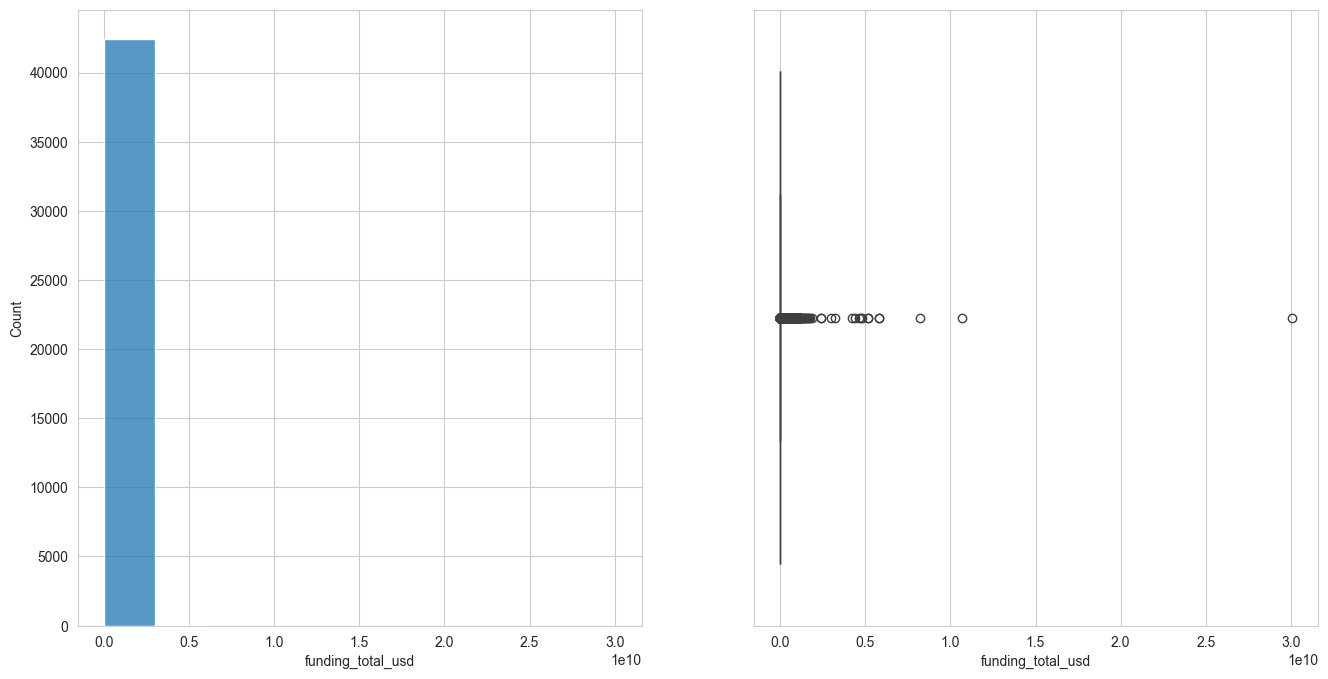

In [693]:
fig, ax = plt.subplots(1, 2, figsize=(16, 8))

sns.histplot(data=df, x='funding_total_usd', bins=10, ax=ax[0])
sns.boxplot(data=df, x='funding_total_usd', ax=ax[1])

plt.show()

Мы видим, что у нас присутствуют выбросы, которые вызваны даже если не вызваны ошибкой, то все равно помешают обучению модели. Остальные выбросы мы оставим, чтобы модель не обучалась в "идеальных" условиях. На первый взгляд, примерно 10-20 самых больших значений являются "критическими" выбросами. Посмотрим и удалим их

In [694]:
# Смотрим самые большие значение и количество раундов финансирования
df.sort_values(by=['funding_total_usd'], ascending=False)[['funding_total_usd', 'funding_rounds']]

,funding_total_usd,funding_rounds
39186,3.007950e+10,5
21241,1.066494e+10,1
4557,8.207450e+09,13
15976,5.820000e+09,6
36634,5.800000e+09,1
...,...,...
52499,NaN,3
52502,NaN,1
52507,NaN,1
52508,NaN,1


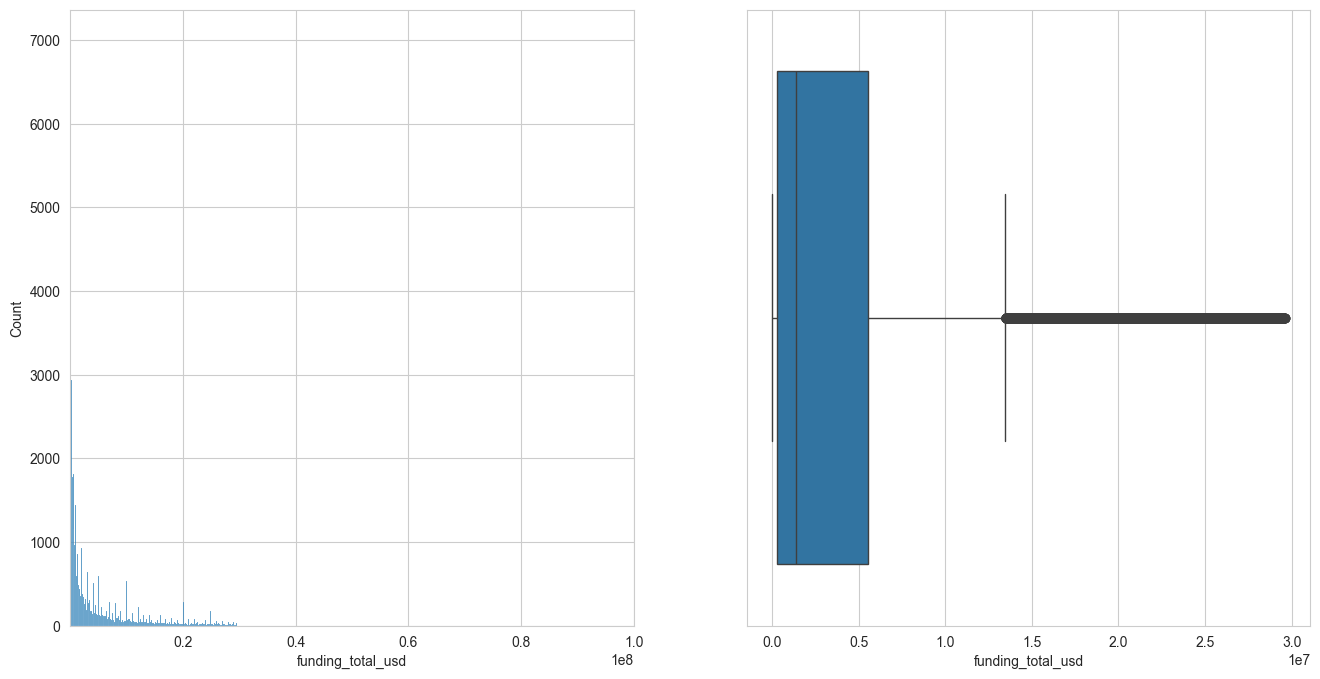

In [695]:
# Удаляем первые 30 самых больших значений
df = df.sort_values('funding_total_usd', ascending=False).iloc[5000:]

fig, ax = plt.subplots(1, 2, figsize=(16, 8))

ax[0].set_xlim(1, 100000000)
sns.histplot(data=df, x='funding_total_usd', bins=200, ax=ax[0])

sns.boxplot(data=df, x='funding_total_usd', ax=ax[1])

plt.show()

In [696]:
# Смотрим уникальные значение кода страны
df['country_code'].unique()

array(['USA', 'CAN', 'NLD', 'FRA', nan, 'GBR', 'CHN', 'MAF', 'IND', 'SWE',
       'TWN', 'DEU', 'DNK', 'IRL', 'ISR', 'AUS', 'JPN', 'AUT', 'LTU',
       'ARG', 'PRT', 'ARE', 'BEL', 'ZAF', 'TUR', 'CHE', 'IDN', 'HKG',
       'FIN', 'ARM', 'BRA', 'ESP', 'MYS', 'CYM', 'SGP', 'KOR', 'RUS',
       'ITA', 'NGA', 'NZL', 'PER', 'CZE', 'CHL', 'EST', 'THA', 'LUX',
       'NOR', 'POL', 'GHA', 'KNA', 'BMU', 'PAN', 'ISL', 'KWT', 'VNM',
       'MEX', 'MNE', 'KEN', 'MLT', 'SVN', 'KAZ', 'EGY', 'URY', 'BGR',
       'PAK', 'BAH', 'TTO', 'HUN', 'PHL', 'LIE', 'ROM', 'UKR', 'GRC',
       'LVA', 'CYP', 'JOR', 'COL', 'SVK', 'GGY', 'TUN', 'TAN', 'SEN',
       'LBN', 'UGA', 'LAO', 'SOM', 'GIB', 'MAR', 'BWA', 'MUS', 'IRN',
       'HRV', 'PRI', 'SRB', 'JAM', 'BGD', 'NIC', 'MCO', 'VEN', 'SAU',
       'CRI', 'KHM', 'BHR', 'ECU', 'DZA', 'CMR', 'BLM', 'SLV', 'MMR',
       'ALB', 'DOM', 'AZE', 'NPL', 'BLZ', 'QAT', 'RWA', 'GTM', 'UZB',
       'GEO', 'BLR', 'MDA', 'SYC', 'ZWE', 'PRY', 'ZMB', 'OMN', 'HND',
       'PSE', '

In [697]:
print(df['country_code'].isna().sum())
df['country_code'].value_counts()

5267


country_code
USA    26125
GBR     2729
CAN     1429
IND     1177
CHN      971
       ...  
KAZ        1
QAT        1
DZA        1
BLM        1
JEY        1
Name: count, Length: 132, dtype: int64

In [698]:
# Посмотрим, какие данные в других столбцах для записей с пропусками в столбце country_code
df.loc[df['country_code'].isna()]

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at
24627,Leyou software,Mobile,29500000.0,operating,NaN,NaN,NaN,NaN,3,2012-04-01,2000-12-01,2008-06-01,NaT
1195,Inspur Group,Networking,29331884.0,operating,NaN,NaN,NaN,NaN,1,2012-03-31,2014-03-01,2014-03-01,NaT
52387,Pevion Biotech,Biotechnology,29160000.0,closed,NaN,NaN,NaN,NaN,1,2006-11-22,2007-08-13,2007-08-13,2009-05-06
20206,Spaltudaq,NaN,29000000.0,operating,NaN,NaN,NaN,NaN,1,2005-12-07,2007-03-19,2007-03-19,NaT
37379,StoreAge,SaaS|Storage|Virtual Worlds,29000000.0,operating,NaN,NaN,NaN,NaN,2,1999-08-07,2001-01-24,2006-06-30,NaT
...,...,...,...,...,...,...,...,...,...,...,...,...,...
52394,Ogg Trading,NaN,NaN,operating,NaN,NaN,NaN,NaN,1,2014-01-26,2015-06-01,2015-06-01,NaT
52404,Beach Bum,NaN,NaN,closed,NaN,NaN,NaN,NaN,1,2014-08-13,2015-05-18,2015-05-18,2017-03-30
52419,"iSend, LLC",NaN,NaN,closed,NaN,NaN,NaN,NaN,1,2007-01-01,2008-05-28,2008-05-28,2009-10-03
52420,Deutsche Startups,News|Startups,NaN,operating,NaN,NaN,NaN,NaN,1,2006-08-18,2007-04-08,2007-04-08,NaT


Мы видим, что данные, с пропуском в столбце `country_code`все еще валидны, поэтому нам нужно заполнить пропуски. Сделаем это, используя моду.

In [699]:
# Заполняем пропуски модой
df['country_code'] = df['country_code'].fillna(df['country_code'].mode()[0])

# Проверяем, остались ли у нас пропуски в данном столбце
df['country_code'].isna().sum()

0

In [700]:
pd.DataFrame(
    {'missing_total': df.isna().sum(),
     'missing_percent': round(df.isna().sum() / df.shape[0] * 100, 1),
     'unique_count': df.nunique(),
     'unique_percent': round(df.nunique() / df.shape[0] * 100, 1),
     }
)

,missing_total,missing_percent,unique_count,unique_percent
name,1,0.0,47515,100.0
category_list,2395,5.0,20599,43.4
funding_total_usd,10069,21.2,12725,26.8
status,0,0.0,2,0.0
country_code,0,0.0,132,0.3
state_code,6442,13.6,297,0.6
region,6061,12.8,1022,2.2
city,6061,12.8,4357,9.2
funding_rounds,0,0.0,16,0.0
founded_at,0,0.0,5157,10.9


In [701]:
def fill_missing_values(dataframe):
    """
    Заполняет пропущенные значения в DataFrame для заданных столбцов с учетом их типа и иерархии.
    Returns:
        pd.DataFrame:
            Модифицированный DataFrame с заполненными пропусками:
            - Для `category_list` и `country_code` — мода (наиболее частое значение).
            - Для `funding_total_usd` — медиана (устойчивая к выбросам).
            - Для `state_code`, `region`, `city` — мода в рамках родительской категории
              (например, `state_code` заполняется по `country_code`). При отсутствии данных
              используется код/название родительской категории .
    """

    # Заполняем пропуски в столбце category_list модой
    dataframe['category_list'] = dataframe['category_list'].fillna(dataframe['category_list'].mode()[0])

    # Заполняем пропуски в столбце funding_total_usd медианой
    dataframe['funding_total_usd'] = dataframe['funding_total_usd'].fillna(dataframe['funding_total_usd'].median())

    # Заполняем пропуски в столбце country_code модой
    dataframe['country_code'] = dataframe['country_code'].fillna(dataframe['country_code'].mode()[0])

    # Заполняем пропуски в столбце state_code модой, сгруппировав данные по country_code
    for code in dataframe['country_code'].unique():
        try:
            # заполняем самым частым значением для определенного кода страны
            dataframe.loc[dataframe['country_code'] == code, 'state_code'] = dataframe.loc[
                dataframe['country_code'] == code, 'state_code'].fillna(
                dataframe.loc[dataframe['country_code'] == code, 'state_code'].mode()[0])
        except:
            # заполняем значением кода страны
            dataframe.loc[dataframe['country_code'] == code, 'state_code'] = dataframe.loc[
                dataframe['country_code'] == code, 'state_code'].fillna(code)

    # Заполняем пропуски в столбце region модой, сгруппировав данные по state_code
    for code in dataframe['state_code'].unique():
        try:
            # заполняем самым частым значением для определенного кода штата
            dataframe.loc[dataframe['state_code'] == code, 'region'] = dataframe.loc[
                dataframe['state_code'] == code, 'region'].fillna(
                dataframe.loc[dataframe['state_code'] == code, 'region'].mode()[0])
        except:
            # заполняем значением кода штата
            dataframe.loc[dataframe['state_code'] == code, 'region'] = dataframe.loc[
                dataframe['state_code'] == code, 'region'].fillna(code)

    # Заполняем пропуски в столбце city модой, сгруппировав данные по region
    for region in dataframe['region'].unique():
        try:
            # Заполняем самым частым значением для определенного региона
            dataframe.loc[dataframe['region'] == region, 'city'] = dataframe.loc[
                dataframe['region'] == region, 'city'].fillna(
                dataframe.loc[dataframe['region'] == region, 'city'].mode()[0])
        except:
            # Заполняем значением названием региона
            dataframe.loc[dataframe['region'] == region, 'city'] = dataframe.loc[
                dataframe['region'] == region, 'city'].fillna(region)

    return dataframe

In [702]:
df = fill_missing_values(df)

In [703]:
pd.DataFrame(
    {'missing_total': df.isna().sum(),
     'missing_percent': round(df.isna().sum() / df.shape[0] * 100, 1),
     'unique_count': df.nunique(),
     'unique_percent': round(df.nunique() / df.shape[0] * 100, 1),
     }
)

,missing_total,missing_percent,unique_count,unique_percent
name,1,0.0,47515,100.0
category_list,0,0.0,20599,43.4
funding_total_usd,0,0.0,12725,26.8
status,0,0.0,2,0.0
country_code,0,0.0,132,0.3
state_code,0,0.0,316,0.7
region,0,0.0,1029,2.2
city,0,0.0,4364,9.2
funding_rounds,0,0.0,16,0.0
founded_at,0,0.0,5157,10.9


Перед обработкой пропусков, мы удалили 30 самых больших значений в столбце `funding_total_usd`, потому что они бы сильно повлияли на обучение модели. Остальные выбросы мы оставили, чтобы модель не обучалась в "идеальных условиях"

Мы создали функцию для заполнения пропусков. Все пропуски были заполнены, основываясь на моде. Заполняли мы их, предварительно сгруппировав данные по "предыдущему столбцу"

### Предобработка в тестовом датасете

Ранее мы создали функцию для предобработки, поэтому сейчас нам достаточно просто применить ее к тестовому датасету. Так как это тестовый датасет, то мы не можем удалять все выбросы

In [704]:
pd.DataFrame(
    {'missing_total': test_df.isna().sum(),
     'missing_percent': round(test_df.isna().sum() / test_df.shape[0] * 100, 1),
     'unique_count': test_df.nunique(),
     'unique_percent': round(test_df.nunique() / test_df.shape[0] * 100, 1),
     }
)

,missing_total,missing_percent,unique_count,unique_percent
name,0,0.0,13125,100.0
category_list,591,4.5,6206,47.3
funding_total_usd,2578,19.6,4549,34.7
country_code,1382,10.5,96,0.7
state_code,1695,12.9,235,1.8
region,1589,12.1,688,5.2
city,1587,12.1,2117,16.1
funding_rounds,0,0.0,15,0.1
first_funding_at,0,0.0,3299,25.1
last_funding_at,0,0.0,3021,23.0


In [705]:
test_df = fill_missing_values(test_df)

In [706]:
pd.DataFrame(
    {'missing_total': test_df.isna().sum(),
     'missing_percent': round(test_df.isna().sum() / test_df.shape[0] * 100, 1),
     'unique_count': test_df.nunique(),
     'unique_percent': round(test_df.nunique() / test_df.shape[0] * 100, 1),
     }
)

,missing_total,missing_percent,unique_count,unique_percent
name,0,0.0,13125,100.0
category_list,0,0.0,6206,47.3
funding_total_usd,0,0.0,4549,34.7
country_code,0,0.0,96,0.7
state_code,0,0.0,243,1.9
region,0,0.0,697,5.3
city,0,0.0,2125,16.2
funding_rounds,0,0.0,15,0.1
first_funding_at,0,0.0,3299,25.1
last_funding_at,0,0.0,3021,23.0


In [707]:
# Удаляем утечку
df = df.drop('closed_at', axis=1)
# test_df = test_df.drop('lifetime', axis=1)

### Вывод:

Во время предобработки данных мы создали функцию для удаления пропусков.

В тренировочным датасете мы удалили 30 самых больших значений. Остальные выбросы мы оставили.

В тестовом датасете мы обработали пропуски, используя функцию.

## Feature engineering

Проведем генерацию признаков: извлечем из дат год, месяц, и день. Так же сократим количество уникальных значений в категориальных столбцах: заменим значения, которые фигурируют мало раз на `other`. Для этого нам надо будет определить, какое значение считается "малым"

In [708]:
df

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at
10480,PlumTV,Media|Television|Web Hosting,29600000.0,closed,USA,NY,New York City,New York,3,2002-01-01,2006-12-22,2012-10-13
23075,Andigilog,Semiconductors,29600000.0,closed,USA,AZ,Phoenix,Tempe,4,1996-01-01,2003-07-18,2007-02-20
17428,Onapsis Inc.,Security,29600000.0,operating,USA,MA,Boston,Boston,3,2009-09-01,2009-01-01,2015-09-15
36918,Profectus Biosciences,Biotechnology,29591206.0,operating,USA,MD,Baltimore,Baltimore,5,2006-04-18,2007-06-15,2014-10-31
34671,ENBALA Power Networks,Clean Technology,29581347.0,operating,CAN,ON,Toronto,Toronto,4,2003-01-01,2010-09-28,2015-09-15
...,...,...,...,...,...,...,...,...,...,...,...,...
52499,StockRadar,Finance|FinTech,1380700.0,operating,CHN,22,Beijing,Beijing,3,2011-01-01,2011-12-01,2015-09-22
52502,Zura!,E-Commerce,1380700.0,operating,BRA,27,BRA - Other,Brasil,1,2007-04-28,2008-01-01,2008-01-01
52507,Proactive Comfort,Medical,1380700.0,operating,USA,MD,Baltimore,Centreville,1,2009-10-16,2011-01-20,2011-01-20
52508,ScramCard,Software,1380700.0,operating,HKG,HKG,Hong Kong,Hong Kong,1,2013-01-01,2015-11-20,2015-11-20


In [709]:
test_df

,name,category_list,funding_total_usd,country_code,state_code,region,city,funding_rounds,first_funding_at,last_funding_at,lifetime
0,Crystalsol,Clean Technology,2819200.0,NIC,17,Copenhagen,Copenhagen,1,2009-07-01,2009-07-01,3501
1,JBI Fish & Wings,Hospitality,2000000.0,USA,TN,TN - Other,Humboldt,1,2010-07-28,2010-07-28,2717
2,COINPLUS,Finance,428257.0,LUX,3,Esch-sur-alzette,Esch-sur-alzette,2,2014-05-15,2014-09-18,1295
3,Imagine Communications,Software|Video|Video Streaming,34700000.0,USA,CA,San Diego,San Diego,4,2005-01-01,2010-04-20,4748
4,DNA13,Software,4530000.0,CAN,ON,Ottawa,Ottawa,1,2007-05-08,2007-05-08,6209
...,...,...,...,...,...,...,...,...,...,...,...
13120,Jymob,Recruiting,28000.0,USA,CA,SF Bay Area,Sunnyvale,1,2012-07-01,2012-07-01,2267
13121,GlobaTrek,Software,2000000.0,USA,CA,SF Bay Area,Mountain View,1,2013-10-01,2013-10-01,2192
13122,Inkd.com,Design|E-Commerce|Marketplaces|Printing,5600000.0,USA,WA,Seattle,Seattle,3,2008-09-01,2011-06-28,2922
13123,AdWill,Advertising Exchanges|Mobile|Mobile Advertising,150000.0,USA,NY,New York City,New York,2,2014-09-27,2014-11-04,1386


In [710]:
df['funding_period'] = (df['last_funding_at'] - df['first_funding_at']).dt.days
df['lifetime'] = (df['last_funding_at'] - df['founded_at']).dt.days
df['log_funding'] = np.log1p(df['funding_total_usd'])
df

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,funding_period,lifetime,log_funding
10480,PlumTV,Media|Television|Web Hosting,29600000.0,closed,USA,NY,New York City,New York,3,2002-01-01,2006-12-22,2012-10-13,2122,3938,17.203285
23075,Andigilog,Semiconductors,29600000.0,closed,USA,AZ,Phoenix,Tempe,4,1996-01-01,2003-07-18,2007-02-20,1313,4068,17.203285
17428,Onapsis Inc.,Security,29600000.0,operating,USA,MA,Boston,Boston,3,2009-09-01,2009-01-01,2015-09-15,2448,2205,17.203285
36918,Profectus Biosciences,Biotechnology,29591206.0,operating,USA,MD,Baltimore,Baltimore,5,2006-04-18,2007-06-15,2014-10-31,2695,3118,17.202988
34671,ENBALA Power Networks,Clean Technology,29581347.0,operating,CAN,ON,Toronto,Toronto,4,2003-01-01,2010-09-28,2015-09-15,1813,4640,17.202655
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52499,StockRadar,Finance|FinTech,1380700.0,operating,CHN,22,Beijing,Beijing,3,2011-01-01,2011-12-01,2015-09-22,1391,1725,14.138102
52502,Zura!,E-Commerce,1380700.0,operating,BRA,27,BRA - Other,Brasil,1,2007-04-28,2008-01-01,2008-01-01,0,248,14.138102
52507,Proactive Comfort,Medical,1380700.0,operating,USA,MD,Baltimore,Centreville,1,2009-10-16,2011-01-20,2011-01-20,0,461,14.138102
52508,ScramCard,Software,1380700.0,operating,HKG,HKG,Hong Kong,Hong Kong,1,2013-01-01,2015-11-20,2015-11-20,0,1053,14.138102


In [711]:
test_df['funding_period'] = (test_df['last_funding_at'] - test_df['first_funding_at']).dt.days
test_df['log_funding'] = np.log1p(test_df['funding_total_usd'])
test_df

,name,category_list,funding_total_usd,country_code,state_code,region,city,funding_rounds,first_funding_at,last_funding_at,lifetime,funding_period,log_funding
0,Crystalsol,Clean Technology,2819200.0,NIC,17,Copenhagen,Copenhagen,1,2009-07-01,2009-07-01,3501,0,14.851964
1,JBI Fish & Wings,Hospitality,2000000.0,USA,TN,TN - Other,Humboldt,1,2010-07-28,2010-07-28,2717,0,14.508658
2,COINPLUS,Finance,428257.0,LUX,3,Esch-sur-alzette,Esch-sur-alzette,2,2014-05-15,2014-09-18,1295,126,12.967481
3,Imagine Communications,Software|Video|Video Streaming,34700000.0,USA,CA,San Diego,San Diego,4,2005-01-01,2010-04-20,4748,1935,17.362250
4,DNA13,Software,4530000.0,CAN,ON,Ottawa,Ottawa,1,2007-05-08,2007-05-08,6209,0,15.326233
...,...,...,...,...,...,...,...,...,...,...,...,...,...
13120,Jymob,Recruiting,28000.0,USA,CA,SF Bay Area,Sunnyvale,1,2012-07-01,2012-07-01,2267,0,10.239996
13121,GlobaTrek,Software,2000000.0,USA,CA,SF Bay Area,Mountain View,1,2013-10-01,2013-10-01,2192,0,14.508658
13122,Inkd.com,Design|E-Commerce|Marketplaces|Printing,5600000.0,USA,WA,Seattle,Seattle,3,2008-09-01,2011-06-28,2922,1030,15.538277
13123,AdWill,Advertising Exchanges|Mobile|Mobile Advertising,150000.0,USA,NY,New York City,New York,2,2014-09-27,2014-11-04,1386,38,11.918397


In [712]:
df['category_list'].value_counts()

category_list
Software                                                                               5365
Biotechnology                                                                          2262
E-Commerce                                                                              985
Mobile                                                                                  822
Curated Web                                                                             816
                                                                                       ... 
Employment|Recruiting|Search|Services                                                     1
Information Technology|Mobile|Photo Sharing                                               1
Collaboration|File Sharing|Group SMS|Mobile|Social Network Media|Video Conferencing       1
Energy|Finance|Risk Management                                                            1
Information Services|Services|Software                            

In [713]:
np.savetxt('categories.txt', df['category_list'].unique(), delimiter=',', fmt='%s')

In [714]:
df['category_list'].nunique()

20599

In [715]:
# Словарь для категорий
manual_mapping = {
    # E-Commerce
    'e-commerce': 'E-Commerce',
    'marketplaces': 'E-Commerce',
    'payments': 'E-Commerce',
    'social commerce': 'E-Commerce',
    'mobile commerce': 'E-Commerce',
    'online shopping': 'E-Commerce',
    'retail technology': 'E-Commerce',
    'e-commerce platforms': 'E-Commerce',
    'logistics': 'E-Commerce',
    'shipping': 'E-Commerce',

    # Healthcare
    'health care': 'Healthcare',
    'medical devices': 'Healthcare',
    'mhealth': 'Healthcare',
    'pharmaceuticals': 'Healthcare',
    'medical': 'Healthcare',
    'hospitals': 'Healthcare',

    # Technology
    'technology': 'Technology',
    'cloud computing': 'Technology',
    'artificial intelligence': 'Technology',
    'machine learning': 'Technology',
    'enterprise software': 'Technology',
    'data security': 'Technology',
    'cyber security': 'Technology',
    'network security': 'Technology',
    'mobile': 'Technology',
    'saas': 'Technology',
    'software': 'Technology',
    'internet of things': 'Technology',
    'wearables': 'Technology',
    'image recognition': 'Technology',

    # Finance
    'finance': 'Finance',
    'fintech': 'Finance',
    'investment management': 'Finance',
    'wealth management': 'Finance',
    'financial services': 'Finance',
    'payments': 'Finance',

    # Education
    'education': 'Education',
    'edtech': 'Education',
    'online education': 'Education',
    'educational games': 'Education',

    # Marketing & Advertising
    'advertising': 'Marketing',
    'social media marketing': 'Marketing',
    'brand marketing': 'Marketing',
    'digital media': 'Marketing',
    'content': 'Marketing',

    # Logistics & Delivery
    'logistics': 'Logistics',
    'shipping': 'Logistics',
    'delivery': 'Logistics',

    # Security
    'security': 'Security',
    'data security': 'Security',
    'network security': 'Security',
    'cyber security': 'Security',

    # Media & Entertainment
    'media': 'Media',
    'entertainment': 'Media',
    'video streaming': 'Media',
    'music': 'Media',
    'games': 'Media',

    # Real Estate
    'real estate': 'Real Estate',
    'property management': 'Real Estate',

    # Travel & Hospitality
    'travel & tourism': 'Travel',
    'hospitality': 'Travel',
    'restaurants': 'Travel',

    # Manufacturing & Industrial
    'manufacturing': 'Manufacturing',
    'industrial': 'Manufacturing',

    # Energy
    'energy management': 'Energy',
    'renewable energies': 'Energy',

    # Agriculture
    'agriculture': 'Agriculture',

    # Automotive
    'cars': 'Automotive',
    'automotive': 'Automotive',

    # Nonprofits & Social
    'nonprofits': 'Nonprofits',
    'social media': 'Nonprofits',

    # Default rule
    'other': 'Other'
}

In [716]:
# Функция для извлечения года, месяца, дня
def extrat_date(col) -> tuple:
    year = col.year
    month = col.month
    day = col.day

    return year, month, day


# Функция для замены значений
def replace_rare_categories(df, thresholds):
    """
    Заменяет категории в столбцах на 'other', если их частота ниже порога.

    Аргументы:
    - df: pandas.DataFrame (датафрейм)
    - thresholds: dict (словарь в формате {столбец: порог})
    """
    for column, threshold in thresholds.items():
        # Подсчет частоты категорий
        value_counts = df[column].value_counts()

        # Создание маски для замены
        mask = df[column].map(value_counts) < threshold

        # Замена значений
        df[column] = df[column].mask(mask, 'other')

    return df


# Функция для приведения категории к глобальной категории
def map_to_global_category(category_str):
    # Разбиваем строку на подкатегории, удаляем пробелы и приводим к нижнему регистру
    subcategories = [subcat.strip().lower() for subcat in category_str.split('|')]
    # Проверяем каждую подкатегорию в словаре
    for subcat in subcategories:
        if subcat in manual_mapping:
            return manual_mapping[subcat]
    # Если не найдено, возвращаем первую подкатегорию или 'Other'
    return subcategories[0] if subcategories else 'Other'

In [717]:
# Устанавливаем пороговое значение
threshold = 1000

country_code_top = df['country_code'].value_counts().index[:threshold].tolist()
state_code_top = df['state_code'].value_counts().index[:threshold].tolist()
region_top = df['region'].value_counts().index[:threshold].tolist()
city_top = df['city'].value_counts().index[:threshold].tolist()

### Feature engineering в тренировочном датафрейме

In [718]:
# Копируем датасет
df_processed = df.copy()

# Все значения, которые не в топе заменяем на other
df_processed.loc[~df_processed['country_code'].isin(country_code_top), 'country_code'] = 'other'
df_processed.loc[~df_processed['state_code'].isin(state_code_top), 'state_code'] = 'other'
df_processed.loc[~df_processed['region'].isin(region_top), 'region'] = 'other'
df_processed.loc[~df_processed['city'].isin(city_top), 'city'] = 'other'

# Сокращаем количество категорий
df_processed['global_category'] = df['category_list'].apply(map_to_global_category)

# Разбиваем на год, месяц, день столбец first_funding_at
df_processed[['first_funding_at_year', 'first_funding_at_month', 'first_funding_at_day']] = df_processed[
    'first_funding_at'].apply(extrat_date).apply(pd.Series)

# Разбиваем на год, месяц, день столбец last_funding_at
df_processed[['last_funding_at_year', 'last_funding_at_month', 'last_funding_at_day']] = df_processed[
    'last_funding_at'].apply(extrat_date).apply(pd.Series)

# Избавляемся от ненужных столбцов
df_processed = df_processed.drop(['name', 'category_list',
                                  'founded_at', 'first_funding_at', 'last_funding_at'],
                                 axis=1)

In [719]:
# Выводим датасет после инженеринга
df_processed

,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,funding_period,lifetime,log_funding,global_category,first_funding_at_year,first_funding_at_month,first_funding_at_day,last_funding_at_year,last_funding_at_month,last_funding_at_day
10480,29600000.0,closed,USA,NY,New York City,New York,3,2122,3938,17.203285,Media,2006,12,22,2012,10,13
23075,29600000.0,closed,USA,AZ,Phoenix,Tempe,4,1313,4068,17.203285,semiconductors,2003,7,18,2007,2,20
17428,29600000.0,operating,USA,MA,Boston,Boston,3,2448,2205,17.203285,Security,2009,1,1,2015,9,15
36918,29591206.0,operating,USA,MD,Baltimore,Baltimore,5,2695,3118,17.202988,biotechnology,2007,6,15,2014,10,31
34671,29581347.0,operating,CAN,ON,Toronto,Toronto,4,1813,4640,17.202655,clean technology,2010,9,28,2015,9,15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52499,1380700.0,operating,CHN,22,Beijing,Beijing,3,1391,1725,14.138102,Finance,2011,12,1,2015,9,22
52502,1380700.0,operating,BRA,27,BRA - Other,Brasil,1,0,248,14.138102,E-Commerce,2008,1,1,2008,1,1
52507,1380700.0,operating,USA,MD,Baltimore,other,1,0,461,14.138102,Healthcare,2011,1,20,2011,1,20
52508,1380700.0,operating,HKG,HKG,Hong Kong,Hong Kong,1,0,1053,14.138102,Technology,2015,11,20,2015,11,20


### Feature engineering в тестовом датасете

In [720]:
# Копируем датасет
test_df_processed = test_df.copy()

# Все значения, которые не в топе заменяем на other
test_df_processed.loc[~test_df_processed['country_code'].isin(country_code_top), 'country_code'] = 'other'
test_df_processed.loc[~test_df_processed['state_code'].isin(state_code_top), 'state_code'] = 'other'
test_df_processed.loc[~test_df_processed['region'].isin(region_top), 'region'] = 'other'
test_df_processed.loc[~test_df_processed['city'].isin(city_top), 'city'] = 'other'

# Сокращаем количество категорий
test_df_processed['global_category'] = df['category_list'].apply(map_to_global_category)

# Разбиваем на год, месяц, день столбец first_funding_at
test_df_processed[['first_funding_at_year', 'first_funding_at_month', 'first_funding_at_day']] = test_df_processed[
    'first_funding_at'].apply(extrat_date).apply(pd.Series)

# Разбиваем на год, месяц, день столбец last_funding_at
test_df_processed[['last_funding_at_year', 'last_funding_at_month', 'last_funding_at_day']] = test_df_processed[
    'last_funding_at'].apply(extrat_date).apply(pd.Series)

# Избавляемся от ненужных столбцов
test_df_processed = test_df_processed.drop(['name', 'first_funding_at', 'last_funding_at', 'category_list'], axis=1)


In [721]:
test_df_processed

,funding_total_usd,country_code,state_code,region,city,funding_rounds,lifetime,funding_period,log_funding,global_category,first_funding_at_year,first_funding_at_month,first_funding_at_day,last_funding_at_year,last_funding_at_month,last_funding_at_day
0,2819200.0,NIC,17,Copenhagen,Copenhagen,1,3501,0,14.851964,Travel,2009,7,1,2009,7,1
1,2000000.0,USA,TN,TN - Other,other,1,2717,0,14.508658,NaN,2010,7,28,2010,7,28
2,428257.0,LUX,3,Esch-sur-alzette,other,2,1295,126,12.967481,NaN,2014,5,15,2014,9,18
3,34700000.0,USA,CA,San Diego,San Diego,4,4748,1935,17.362250,Healthcare,2005,1,1,2010,4,20
4,4530000.0,CAN,ON,Ottawa,Ottawa,1,6209,0,15.326233,Manufacturing,2007,5,8,2007,5,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13120,28000.0,USA,CA,SF Bay Area,Sunnyvale,1,2267,0,10.239996,Finance,2012,7,1,2012,7,1
13121,2000000.0,USA,CA,SF Bay Area,Mountain View,1,2192,0,14.508658,Technology,2013,10,1,2013,10,1
13122,5600000.0,USA,WA,Seattle,Seattle,3,2922,1030,15.538277,hardware + software,2008,9,1,2011,6,28
13123,150000.0,USA,NY,New York City,New York,2,1386,38,11.918397,E-Commerce,2014,9,27,2014,11,4


In [722]:
print(set(test_df_processed['country_code']) - set(df_processed['country_code']))
print(set(test_df_processed['state_code']) - set(df_processed['state_code']))
print(set(test_df_processed['region']) - set(df_processed['region']))
print(set(test_df_processed['city']) - set(df_processed['city']))
print(set(test_df_processed['global_category']) - set(df_processed['global_category']))

{'other'}
{'other'}
set()
set()
{nan}


### Вывод

Мы написали 2 функции:
1. Функция, которая выделяет год, месяц, день из столбцов `first_funding_at`, `last_funding_at`. Столбец `founded_at` `closed_at` мы удалили из тренировочного датасета, так как их нет в тестовом датасете.
2. Функция, которая заменяет "малые" значения в категориальных столбцах на значение `other`. Пороги для замены мы оперделили, используя столбчатую диаграмму

Мы создали 2 новых датасета: `df_processed` и `test_df_processed`. В них мы избавились от лишних столбцов, которые не участвуют в обучении и предсказании модели, а так же применили к ним наши функции.

## Корреляционный анализ данных

In [723]:
df_processed

,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,funding_period,lifetime,log_funding,global_category,first_funding_at_year,first_funding_at_month,first_funding_at_day,last_funding_at_year,last_funding_at_month,last_funding_at_day
10480,29600000.0,closed,USA,NY,New York City,New York,3,2122,3938,17.203285,Media,2006,12,22,2012,10,13
23075,29600000.0,closed,USA,AZ,Phoenix,Tempe,4,1313,4068,17.203285,semiconductors,2003,7,18,2007,2,20
17428,29600000.0,operating,USA,MA,Boston,Boston,3,2448,2205,17.203285,Security,2009,1,1,2015,9,15
36918,29591206.0,operating,USA,MD,Baltimore,Baltimore,5,2695,3118,17.202988,biotechnology,2007,6,15,2014,10,31
34671,29581347.0,operating,CAN,ON,Toronto,Toronto,4,1813,4640,17.202655,clean technology,2010,9,28,2015,9,15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52499,1380700.0,operating,CHN,22,Beijing,Beijing,3,1391,1725,14.138102,Finance,2011,12,1,2015,9,22
52502,1380700.0,operating,BRA,27,BRA - Other,Brasil,1,0,248,14.138102,E-Commerce,2008,1,1,2008,1,1
52507,1380700.0,operating,USA,MD,Baltimore,other,1,0,461,14.138102,Healthcare,2011,1,20,2011,1,20
52508,1380700.0,operating,HKG,HKG,Hong Kong,Hong Kong,1,0,1053,14.138102,Technology,2015,11,20,2015,11,20


/Users/moncervers/PycharmProjects/startup_closure_prediction/.venv/lib/python3.12/site-packages/phik/data_quality.py:59: UserWarning: The number of unique values of variable city is large: 1001. Are you sure this is not an interval variable? Analysis for pairs of variables including city can be slow.
  warnings.warn(
/Users/moncervers/PycharmProjects/startup_closure_prediction/.venv/lib/python3.12/site-packages/phik/data_quality.py:59: UserWarning: The number of unique values of variable region is large: 1001. Are you sure this is not an interval variable? Analysis for pairs of variables including region can be slow.
  warnings.warn(
/Users/moncervers/PycharmProjects/startup_closure_prediction/.venv/lib/python3.12/site-packages/phik/data_quality.py:59: UserWarning: The number of unique values of variable city is large: 1001. Are you sure this is not an interval variable? Analysis for pairs of variables including city can be slow.
  warnings.warn(
/Users/moncervers/PycharmProjects/start

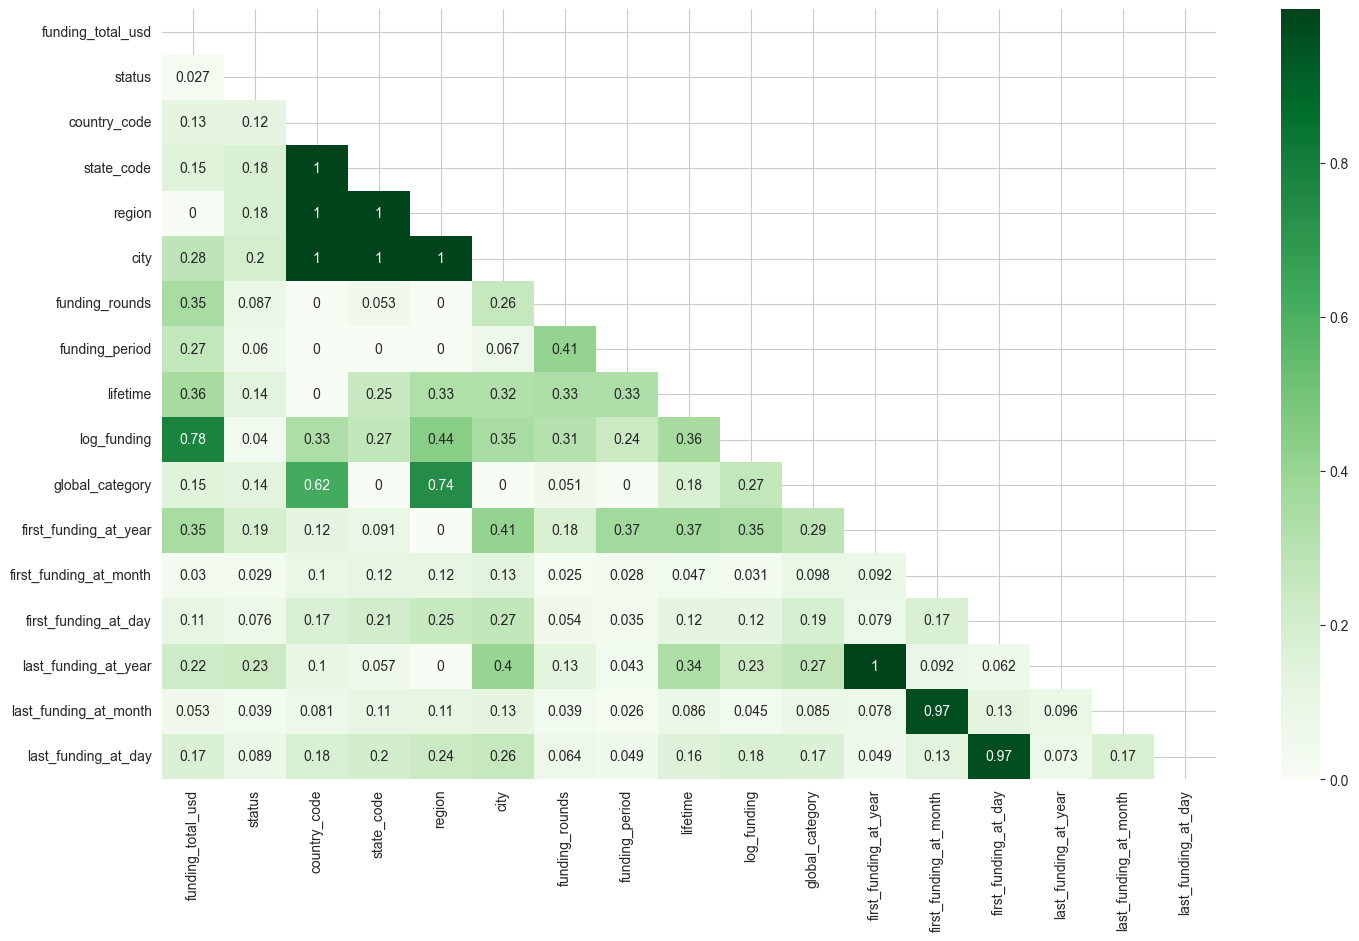

In [724]:
plt.figure(figsize=(17, 10))

ic = ['funding_rounds', 'funding_period', 'lifetime', 'log_funding', 'funding_total_usd',
      'first_funding_at_year', 'first_funding_at_month', 'first_funding_at_day',
      'last_funding_at_year', 'last_funding_at_month', 'last_funding_at_day']
sns.heatmap(
    df_processed.phik_matrix(interval_cols=ic),
    annot=True, cmap='Greens',
    mask=(np.triu(
        np.ones_like(df_processed.phik_matrix(interval_cols=ic), dtype=bool)))
)

plt.show()

Мы видим, что у целевого признака невероятно маленькая корреляция с признаками `first_funding_at_month`, `first_funding_at_day`, `last_funding_at_month`, `last_funding_at_day`. Удалим их

/Users/moncervers/PycharmProjects/startup_closure_prediction/.venv/lib/python3.12/site-packages/phik/data_quality.py:59: UserWarning: The number of unique values of variable city is large: 1001. Are you sure this is not an interval variable? Analysis for pairs of variables including city can be slow.
  warnings.warn(
/Users/moncervers/PycharmProjects/startup_closure_prediction/.venv/lib/python3.12/site-packages/phik/data_quality.py:59: UserWarning: The number of unique values of variable region is large: 1001. Are you sure this is not an interval variable? Analysis for pairs of variables including region can be slow.
  warnings.warn(
/Users/moncervers/PycharmProjects/startup_closure_prediction/.venv/lib/python3.12/site-packages/phik/data_quality.py:59: UserWarning: The number of unique values of variable city is large: 1001. Are you sure this is not an interval variable? Analysis for pairs of variables including city can be slow.
  warnings.warn(
/Users/moncervers/PycharmProjects/start

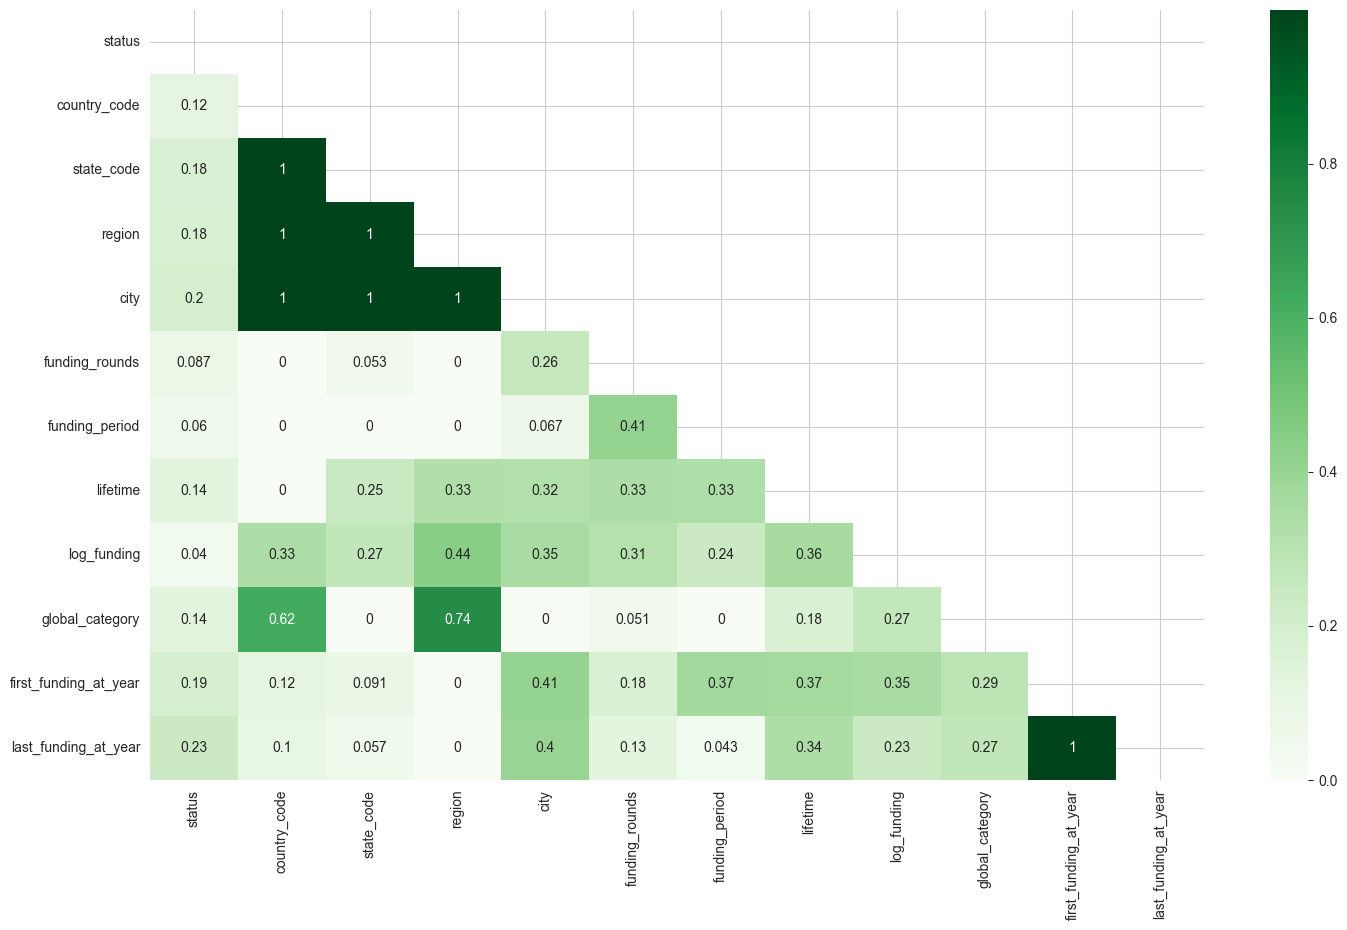

In [725]:
plt.figure(figsize=(17, 10))

# Удаляем ненужные столбцы
df_processed = df_processed.drop(
    ['first_funding_at_day', 'first_funding_at_month',
     'last_funding_at_day', 'last_funding_at_month',
     'funding_total_usd'], axis=1)
test_df_processed = test_df_processed.drop(
    ['first_funding_at_day', 'first_funding_at_month',
     'last_funding_at_day', 'last_funding_at_month',
     'funding_total_usd'], axis=1)

ic = ['funding_rounds', 'funding_period', 'lifetime', 'log_funding', 'last_funding_at_year', 'first_funding_at_year']
sns.heatmap(
    df_processed.phik_matrix(
        interval_cols=ic),
    annot=True, cmap='Greens',
    mask=(np.triu(
        np.ones_like(df_processed.phik_matrix(interval_cols=ic), dtype=bool)))
)

plt.show()

Мы видим, у целевого признака `status` небольшая корреляция со всеми признаками. Наибольшая корреляция у него с годом первого и последнего спонсирования. Мы так же можем наблюдать мультиколлинеарность между всеми "географическими" столбцами, и `first_founded_at_year` вместе с `last_founded_at_year`. Однако это не помешает обучению модели, так что оставим все как есть


### Вывод:

Целовой признак не имеет высокой корреляции ни с одним из признаков. Столбцы `first_funding_at_month`, `first_funding_at_day`, `last_funding_at_month`, `last_funding_at_day` мы удалили, так как корреляция с целевым была ниже 0.1. Некоторые столбцы мультиколлинеарны, однако это не является для нас проблемой, так как мультиколлинеарности с целевым признаком нет.

## Исследовательский анализ

In [726]:
num_col_names = ['funding_rounds', 'funding_period', 'lifetime', 'log_funding',
                 'first_funding_at_year', 'last_funding_at_year']
cat_col_names = ['country_code', 'state_code', 'region', 'city', 'global_category', ]

In [727]:
# # Пример для числовых признаков
# # numeric_features = ['log_funding', 'funding_rounds','funding_period', 'first_funding_at_year', 'last_funding_at_year', 'lifetime']
# num_col_names = ['funding_rounds', 'funding_period', 'lifetime', 'log_funding',
#                  'first_funding_at_year', 'last_funding_at_year']
# cat_col_names = ['country_code', 'state_code', 'region', 'city', 'global_category', ]
#
# # plt.figure(figsize=(17, 10))
#
# fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(20, 10))
#
# for i in range(len(num_col_names)):
#     sns.kdeplot(df_processed[num_col_names[i]], label='Train', fill=True, ax=axes[i,j])
#     sns.kdeplot(test_df_processed[num_col_names[i]], label='Test', fill=True, ax=axes[i,j])
#     plt.title(f'Distribution of {num_col_names[i]}')
#     plt.legend()
#     plt.show()
#
# # Пример для категориальных признаков
# # categorical_features = ['country_code', 'state_code', 'region', 'city', 'global_category']
#
# # for feature in cat_col_names:
# #     print(f"Train distribution for {feature}:")
# #     print(df_processed[feature].value_counts(normalize=True).head())
# #     print(f"Test distribution for {feature}:")
# #     print(test_df_processed[feature].value_counts(normalize=True).head())

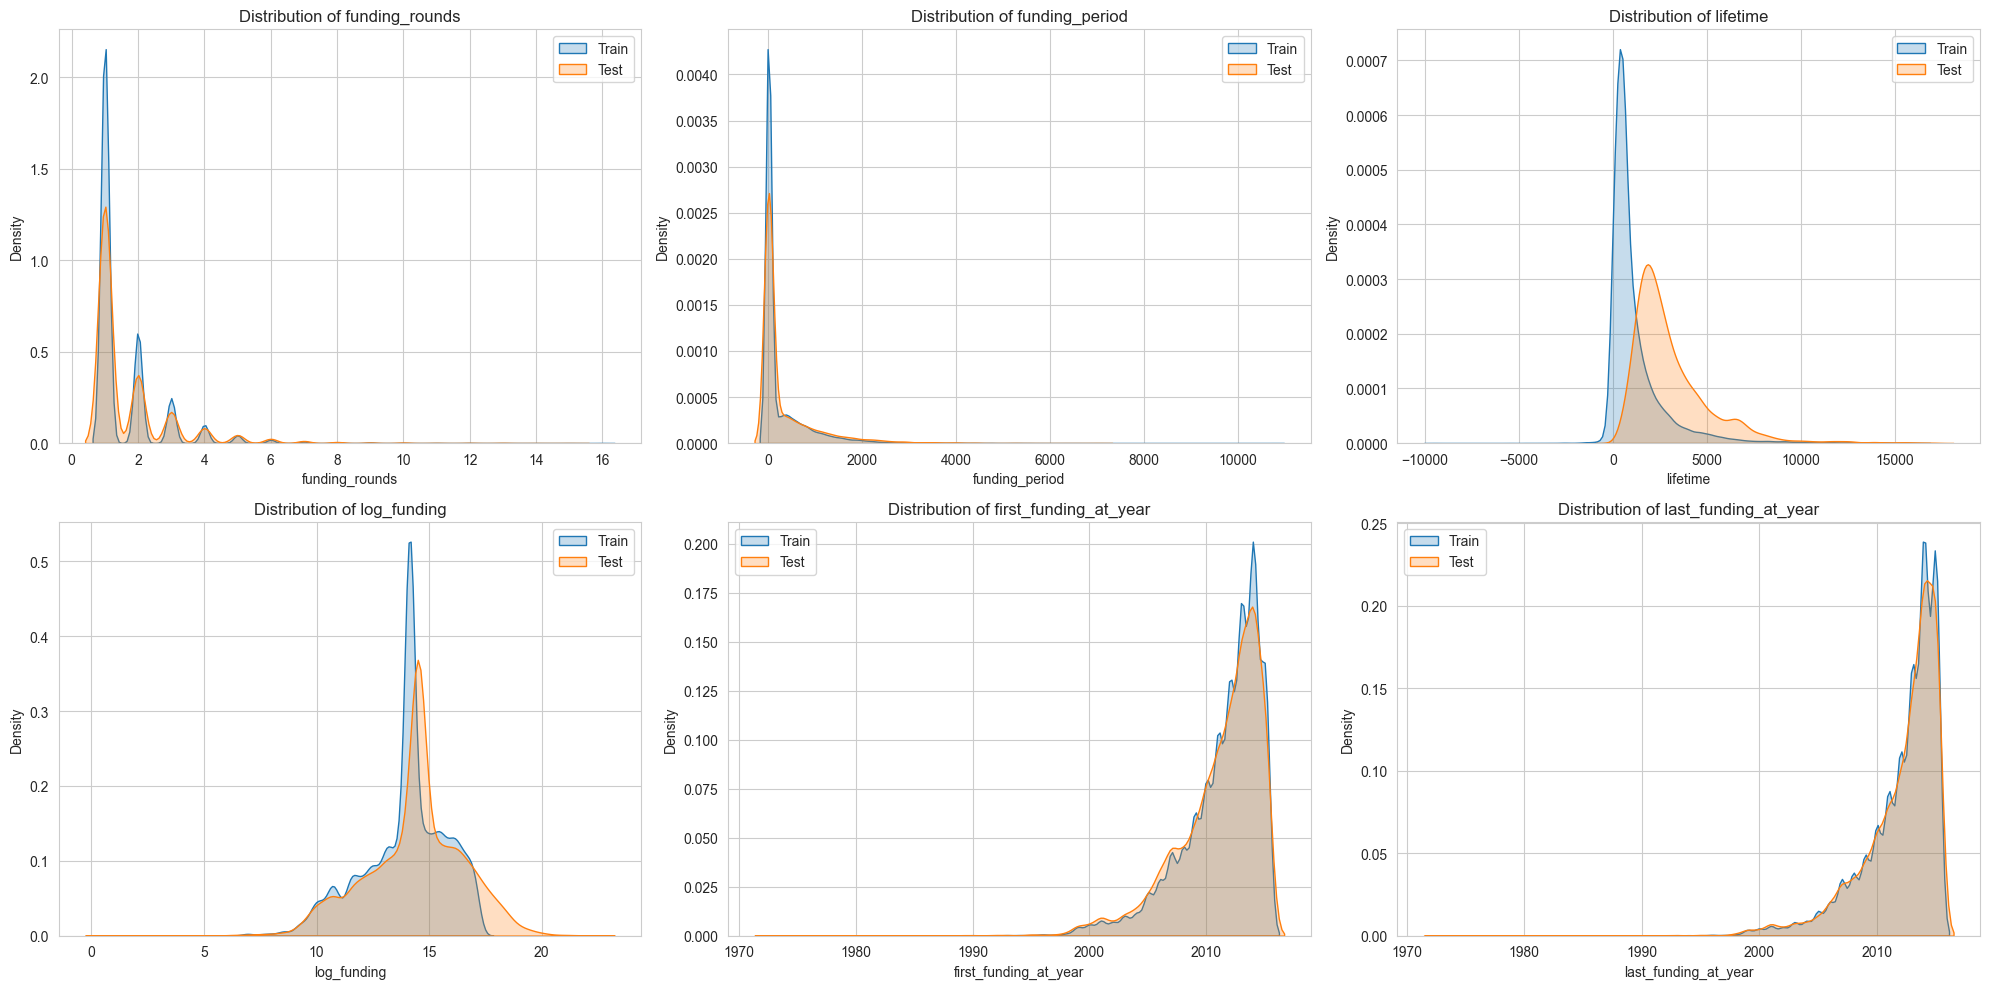

In [728]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(20, 10))

# Проходим по всем числовым признакам
for idx, col in enumerate(num_col_names):
    # Вычисляем индексы строки (i) и столбца (j)
    i = idx // 3  # Номер строки (0 или 1)
    j = idx % 3  # Номер столбца (0, 1 или 2)

    # Строим KDE-графики для тренировочных и тестовых данных
    sns.kdeplot(df_processed[col], label='Train', fill=True, ax=axes[i, j])
    sns.kdeplot(test_df_processed[col], label='Test', fill=True, ax=axes[i, j])

    # Добавляем заголовок и легенду
    axes[i, j].set_title(f'Distribution of {col}')
    axes[i, j].legend()

# Настройка макета для избежания пересечения подписей
plt.tight_layout()
plt.show()

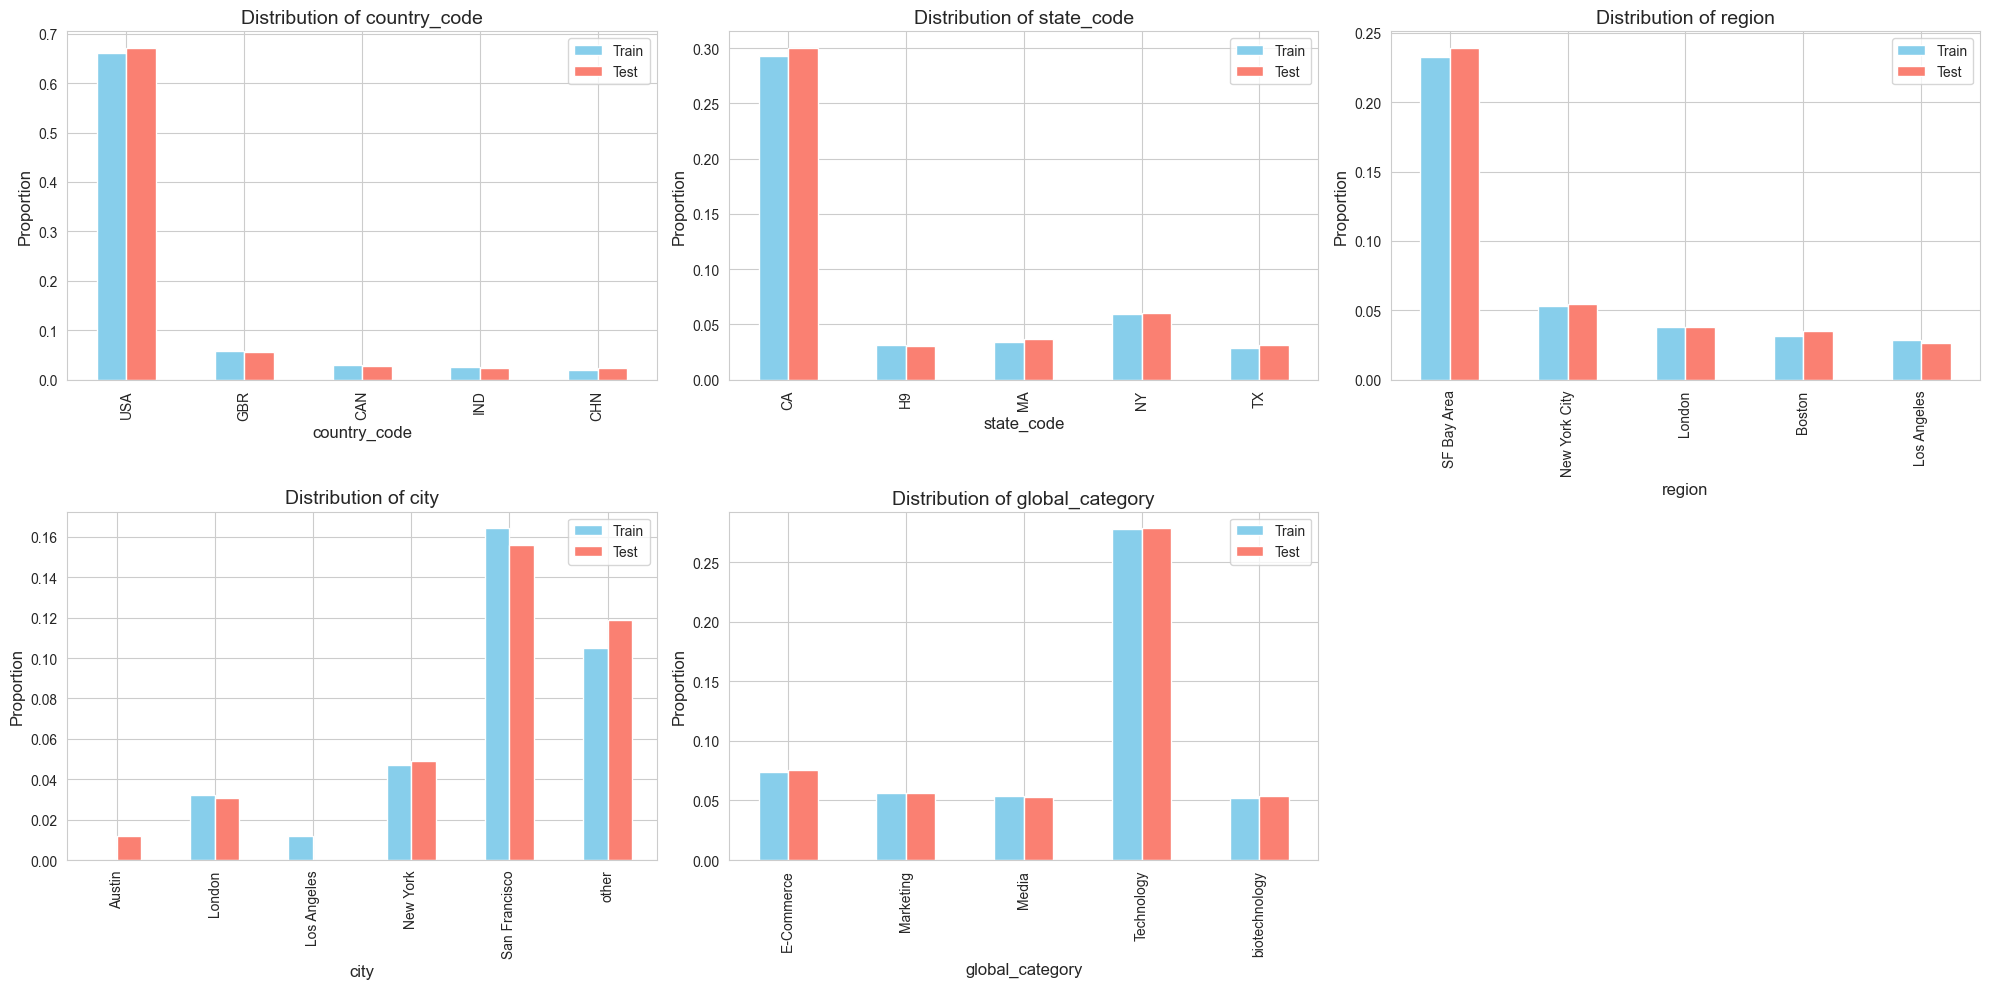

In [729]:
# Создаем сетку графиков
n_cols = 3  # Количество столбцов в сетке
n_rows = (len(cat_col_names) + n_cols - 1) // n_cols  # Количество строк в сетке
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(20, 5 * n_rows))

# Проходим по всем категориальным признакам
for i, feature in enumerate(cat_col_names):
    row = i // n_cols  # Индекс строки
    col = i % n_cols  # Индекс столбца

    # Вычисляем нормализованные распределения
    train_dist = df_processed[feature].value_counts(normalize=True).head(5)
    test_dist = test_df_processed[feature].value_counts(normalize=True).head(5)

    # Объединяем данные для визуализации
    combined_dist = pd.DataFrame({
        'Train': train_dist,
        'Test': test_dist
    }).fillna(0)  # Заполняем отсутствующие категории нулями

    # Строим график
    ax = axes[row, col] if n_rows > 1 else axes[col]
    combined_dist.plot(kind='bar', ax=ax, color=['skyblue', 'salmon'])
    ax.set_title(f'Distribution of {feature}', fontsize=14)
    ax.set_ylabel('Proportion', fontsize=12)
    ax.set_xlabel(feature, fontsize=12)
    ax.legend(['Train', 'Test'])

# Убираем пустые графики, если их больше, чем признаков
if len(cat_col_names) < n_rows * n_cols:
    for j in range(len(cat_col_names), n_rows * n_cols):
        fig.delaxes(axes.flatten()[j])

# Настройка макета
plt.tight_layout()
plt.show()

## Создание пайплайна

Соберем пайплайн для кодирования числовых и категориальных значений. Потом создадим сетку параметров для нашего пайплайна, и посмотрим на метрику, используя RandomizedSearchCV

In [730]:
df_processed = df_processed.drop(['lifetime', 'last_funding_at_year', 'first_funding_at_year'], axis=1)
test_df_processed = test_df_processed.drop(['lifetime', 'last_funding_at_year', 'first_funding_at_year'], axis=1)

In [731]:
set(df_processed.columns) - set(test_df_processed.columns)

{'status'}

In [732]:
# Определяем числовые и категориальные столбцы
num_col_names = ['funding_rounds', 'funding_period', 'log_funding',]
cat_col_names = ['country_code', 'state_code', 'region', 'city', 'global_category' ]

# Пайплайн для числовых значений
num_pipeline = Pipeline([
    (
        'ImputerBeforeScaler',
        SimpleImputer(strategy='most_frequent', missing_values=np.nan)
    ),
    (
        'num',
        StandardScaler()
    )
])

# Пайплайн для категориальных значений
ohe_pipeline = Pipeline([
    # (
    #     'ImputerBeforeOhe',
    #     SimpleImputer(strategy='constant', fill_value='other')
    # ),
    (
        'OneHotEncoder',
        OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)
    )
])

# Собираем в один пайплайн по подготовке данных
data_preprocessor = ColumnTransformer(
    [
        ('num', num_pipeline, num_col_names),
        ('ohe', ohe_pipeline, cat_col_names),
    ],
    remainder='passthrough',
)

# Собираем все в конечный пайплайн
final_pipeline = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('model', DummyClassifier(strategy='median')),
    ]
)

In [733]:
param_grid = [
    # Сетка параметров для логистической регрессии
    {
        'model': [LogisticRegression(random_state=RANDOM_STATE)],
        'model__C': [0.1, 1, 10, 100],
        'model__penalty': ['l2', 'none'],
        'model__max_iter': range(10, 1000),
        'model__class_weight': ['balanced'],
        'preprocessor__num': [MinMaxScaler(), StandardScaler(), RobustScaler(), 'passthrough'],
        # 'select_k_best__k': range(1, X_train.shape[1] + 1),
    },

    # Сетка параметров для метода опорных векторов
    {
        'model': [SVC(random_state=RANDOM_STATE)],
        'model__C': [0.1, 1, 10, 100],
        'model__degree': range(1, 11),
        'model__kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
        'model__class_weight': ['balanced'],
        'preprocessor__num': [MinMaxScaler(), StandardScaler(), RobustScaler(), 'passthrough'],
        # 'select_k_best__k': range(1, X_train.shape[1] + 1),
    },

    # Сетка параметров для метода ближайших соседей
    {
        'model': [KNeighborsClassifier(n_jobs=-1)],
        'model__n_neighbors': range(3, 21),
        'preprocessor__num': [MinMaxScaler(), StandardScaler(), RobustScaler(), 'passthrough'],
        # 'select_k_best__k': range(1, X_train.shape[1] + 1),
    },

    # Стека параметров для дерева решений
    {
        'model': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'model__max_depth': range(2, 50),
        'model__min_samples_split': range(2, 50),
        'model__min_samples_leaf': range(2, 50),
        'model__class_weight': ['balanced'],
        'preprocessor__num': [MinMaxScaler(), StandardScaler(), RobustScaler(), 'passthrough'],
        # 'select_k_best__k': range(1, X_train.shape[1] + 1),
    },

    # Сетка параметров для XGBoost
    {
        'model': [XGBClassifier(random_state=RANDOM_STATE, n_jobs=-1)],
        'model__n_estimators': range(100, 400, 50),
        'model__max_depth': [4, 5, 6],
        'model__learning_rate': [0.01, 0.1, 0.3],  #TODO посмотреть, что означает и подобрать лучшие гиперпараметры
        'model__subsample': [0.8, 1.0],
        'model__colsample_bytree': [0.8, 1.0],
        'model__reg_alpha': [0, 0.1, 1],
        'model__reg_lambda': [0, 0.1, 1],
        'preprocessor__num': [StandardScaler(), RobustScaler(), 'passthrough'],
    },
]

### Вывод:

Мы создали пайплайн и сетку гиперпараметров для 5-и моделей:
1. `Logistic Regression`
2. `SVC`
3. `KNeighborsClassifier`
4. `DecisionTreeClassifier`
5. `XGBClassifier`

## Обучение модели

Используем RandomizedSearchCV для подбора гиперпараметров

In [734]:
# Создаем RandomizedSearchCV для кросс-валидации
rs = RandomizedSearchCV(
    estimator=final_pipeline,
    param_distributions=param_grid,
    scoring='f1',
    n_jobs=-1,
    n_iter=50,
    cv=5,
    random_state=RANDOM_STATE,
)

In [735]:
X = df_processed.drop('status', axis=1)
y = df_processed['status']

# Разбиваем датафрейм на выборки
X_train, X_valid, y_train, y_valid = train_test_split(X,
                                                      y,
                                                      test_size=0.25,
                                                      stratify=y,
                                                      random_state=RANDOM_STATE)

# Объявляем label encoder
le = LabelEncoder()

# Обучаем энкодер
y_train = le.fit_transform(y_train)
# Проставляем классы: 'closed' = 0, 'operating' = 1
le.classes_ = np.array(['closed', 'operating'])
# Кодируем данные в валидационной выборке
y_valid = le.transform(y_valid)

In [736]:
X_train

,country_code,state_code,region,city,funding_rounds,funding_period,log_funding,global_category
46197,USA,CA,SF Bay Area,Mountain View,1,0,14.077876,Technology
24816,USA,CA,Los Angeles,Van Nuys,1,0,13.815512,Nonprofits
44195,JAM,8,Kingston,Kingston,1,0,10.373522,Marketing
23094,USA,CT,Hartford,Westport,1,0,14.740008,Technology
4034,USA,MI,Grand Rapids,Grand Rapids,1,0,14.138102,apps
...,...,...,...,...,...,...,...,...
32498,FRA,A8,Paris,Paris,1,0,13.694710,Media
19027,USA,MN,Minneapolis,Minneapolis,2,0,14.497092,Technology
35902,USA,FL,Jacksonville,Jacksonville,1,0,13.937729,hardware + software
29834,DNK,17,Copenhagen,Copenhagen,1,0,15.555310,Healthcare


In [737]:
# Обучаем модель
rs.fit(X_train, y_train)

/Users/moncervers/PycharmProjects/startup_closure_prediction/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1, 2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/moncervers/PycharmProjects/startup_closure_prediction/.venv/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/Users/moncervers/PycharmProjects/startup_closure_prediction/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1, 2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/moncervers/PycharmProjects/startup_closure_prediction/.venv/lib/python3.12/site-packages/sklearn/preprocessin

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('num',
                                                                               Pipeline(steps=[('ImputerBeforeScaler',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('num',
                                                                                                StandardScaler())]),
                                                                               ['funding_rounds',
                                                                                'funding_period',
                                                                                'log_funding']),
                                                                              ('ohe',
                                                                               Pipeline(steps=[('OneHotEncoder',
                                                                                                OneHotEncoder(drop='fir...
                                                                 num_parallel_tree=None, ...)],
                                         'model__colsample_bytree': [0.8, 1.0],
                                         'model__learning_rate': [0.01, 0.1,
                                                                  0.3],
                                         'model__max_depth': [4, 5, 6],
                                         'model__n_estimators': range(100, 400, 50),
                                         'model__reg_alpha': [0, 0.1, 1],
                                         'model__reg_lambda': [0, 0.1, 1],
                                         'model__subsample': [0.8, 1.0],
                                         'preprocessor__num': [StandardScaler(),
                                                               RobustScaler(),
                                                               'passthrough']}],
                   random_state=42, scoring='f1')

In [738]:
# Выводим метрику на тренировочной выборке
print('f1_score:', round(rs.best_score_, 5))

f1_score: 0.94937


In [739]:
rs.best_params_

{'preprocessor__num': 'passthrough',
 'model__subsample': 0.8,
 'model__reg_lambda': 1,
 'model__reg_alpha': 0.1,
 'model__n_estimators': 250,
 'model__max_depth': 6,
 'model__learning_rate': 0.01,
 'model__colsample_bytree': 0.8,
 'model': XGBClassifier(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=None, device=None, early_stopping_rounds=None,
               enable_categorical=False, eval_metric=None, feature_types=None,
               feature_weights=None, gamma=None, grow_policy=None,
               importance_type=None, interaction_constraints=None,
               learning_rate=None, max_bin=None, max_cat_threshold=None,
               max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
               max_leaves=None, min_child_weight=None, missing=nan,
               monotone_constraints=None, multi_strategy=None, n_estimators=None,
               n_jobs=-1, num_parallel_tree=N

In [740]:
# Создаем датафрейм с истинным статусом, вероятностью, и предсказанием
predictions = pd.DataFrame({
    'actual': y_valid,
    'rs_proba': rs.best_estimator_.predict_proba(X_valid)[:, 1],
})

/Users/moncervers/PycharmProjects/startup_closure_prediction/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1, 2, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [741]:
# # Смотрим метрику на валидационной метрике
# f1_score(predictions['actual'], predictions['prediction'])

### XGBClassifier

In [742]:
X_train_transformed = data_preprocessor.fit_transform(X_train)
X_valid_transformed = data_preprocessor.transform(X_valid)

/Users/moncervers/PycharmProjects/startup_closure_prediction/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1, 2, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [743]:
# from optuna import distributions
# from optuna.integration import OptunaSearchCV
# from xgboost import XGBClassifier

# Определение сетки гиперпараметров
xgbc_params = {
    'n_estimators': distributions.IntDistribution(100, 500, step=50),  # Количество деревьев
    'max_depth': distributions.IntDistribution(3, 10),  # Максимальная глубина дерева
    'learning_rate': distributions.FloatDistribution(0.01, 0.3, log=True),  # Скорость обучения
    'subsample': distributions.FloatDistribution(0.6, 1.0),  # Доля выборки для обучения каждого дерева
    'colsample_bytree': distributions.FloatDistribution(0.6, 1.0),  # Доля признаков для каждого дерева
    'reg_alpha': distributions.FloatDistribution(0, 1.0),  # L1-регуляризация
    'reg_lambda': distributions.FloatDistribution(0, 1.0),  # L2-регуляризация
    'min_child_weight': distributions.IntDistribution(1, 10),  # Минимальный вес для создания нового узла
    'gamma': distributions.FloatDistribution(0, 1.0),  # Минимальное снижение потерь для создания нового узла
}

# Создаем OptunaSearchCV
xgbc_optuna_cv = OptunaSearchCV(
    estimator=XGBClassifier(
        random_state=RANDOM_STATE,
        n_jobs=-1,
        objective='binary:logistic',  # Фиксированное значение для бинарной классификации
        eval_metric='logloss'  # Метрика для оценки качества модели
    ),
    param_distributions=xgbc_params,
    scoring='f1',  # Метрика для оптимизации
    n_trials=50,  # Количество испытаний
    cv=5,  # Кросс-валидация
    n_jobs=-1  # Использование всех ядер
)

# Запускаем поиск гиперпараметров
xgbc_optuna_cv.fit(X_train_transformed, y_train)

/var/folders/d5/3r484lmx4rx7jdlt6zl0_bkc0000gn/T/ipykernel_47858/4022225425.py:19: ExperimentalWarning: OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
  xgbc_optuna_cv = OptunaSearchCV(
[I 2025-04-04 22:36:58,946] A new study created in memory with name: no-name-6682188c-b02f-4208-801c-623ec267fc97
[I 2025-04-04 22:38:40,348] Trial 3 finished with value: 0.949298009701965 and parameters: {'n_estimators': 100, 'max_depth': 9, 'learning_rate': 0.11627167476332716, 'subsample': 0.7675560949573871, 'colsample_bytree': 0.9807284979656524, 'reg_alpha': 0.3108195794550953, 'reg_lambda': 0.2383863638559377, 'min_child_weight': 7, 'gamma': 0.7340312472639515}. Best is trial 3 with value: 0.949298009701965.
[I 2025-04-04 22:38:40,573] Trial 4 finished with value: 0.9493499199582374 and parameters: {'n_estimators': 150, 'max_depth': 5, 'learning_rate': 0.05050187969770108, 'subsample': 0.972177198546923, 'colsample_bytree': 0.8358286543330588, 're

OptunaSearchCV(cv=5,
               estimator=XGBClassifier(base_score=None, booster=None,
                                       callbacks=None, colsample_bylevel=None,
                                       colsample_bynode=None,
                                       colsample_bytree=None, device=None,
                                       early_stopping_rounds=None,
                                       enable_categorical=False,
                                       eval_metric='logloss',
                                       feature_types=None, feature_weights=None,
                                       gamma=None, grow_policy=None,
                                       importance_type=None,
                                       interaction_constrai...
                                    'min_child_weight': IntDistribution(high=10, log=False, low=1, step=1),
                                    'n_estimators': IntDistribution(high=500, log=False, low=100, step=50),
                                    'reg_alpha': FloatDistribution(high=1.0, log=False, low=0.0, step=None),
                                    'reg_lambda': FloatDistribution(high=1.0, log=False, low=0.0, step=None),
                                    'subsample': FloatDistribution(high=1.0, log=False, low=0.6, step=None)},
               scoring='f1')

In [744]:
print("Лучшие параметры:", xgbc_optuna_cv.best_params_)
print("Лучший F1-score:", xgbc_optuna_cv.best_score_)

Лучшие параметры: {'n_estimators': 250, 'max_depth': 8, 'learning_rate': 0.035438196613084144, 'subsample': 0.6559529806270996, 'colsample_bytree': 0.7789161185695789, 'reg_alpha': 0.6172278783270712, 'reg_lambda': 0.00570005646973909, 'min_child_weight': 3, 'gamma': 0.6006491935027805}
Лучший F1-score: 0.9494499528582582


In [745]:
predictions['xgbc_proba'] = xgbc_optuna_cv.best_estimator_.predict_proba(X_valid_transformed)[:, 1]
predictions

,actual,rs_proba,xgbc_proba
0,1,0.929594,0.963897
1,1,0.887460,0.891519
2,1,0.927159,0.939788
3,1,0.917970,0.916314
4,1,0.922504,0.927032
...,...,...,...
11874,1,0.956161,0.981657
11875,1,0.944102,0.934975
11876,1,0.950676,0.954968
11877,1,0.899576,0.879695


### Catboost

In [746]:
# Определение сетки гиперпараметров
catboost_params = {
    'iterations': distributions.IntDistribution(100, 1000, step=50),  # Количество итераций (деревьев)
    'learning_rate': distributions.FloatDistribution(0.01, 0.3, log=True),  # Скорость обучения
    'depth': distributions.IntDistribution(4, 10),  # Глубина каждого дерева
    'l2_leaf_reg': distributions.FloatDistribution(1e-8, 100, log=True),  # L2-регуляризация
    'bagging_temperature': distributions.FloatDistribution(0.0, 1.0),  # Температура бэггинга
    'random_strength': distributions.FloatDistribution(1e-8, 10, log=True),  # Сила случайности при выборе разбиений
    'border_count': distributions.IntDistribution(32, 255),  # Количество разбиений для числовых признаков
    'grow_policy': distributions.CategoricalDistribution(['SymmetricTree', 'Depthwise', 'Lossguide']),
    # Стратегия роста деревьев
    'auto_class_weights': distributions.CategoricalDistribution(['None', 'Balanced', 'SqrtBalanced']),
    # Автоматическая балансировка классов
}

# Создаем OptunaSearchCV
catboost_optuna_cv = OptunaSearchCV(
    estimator=CatBoostClassifier(
        random_state=RANDOM_STATE,
        verbose=False,  # Отключаем вывод логов CatBoost
        thread_count=-1  # Используем все доступные ядра
    ),
    param_distributions=catboost_params,
    scoring='f1',  # Метрика для оптимизации
    n_trials=50,  # Количество испытаний
    cv=5,  # Кросс-валидация
    n_jobs=-1  # Использование всех ядер
)

# Запускаем поиск гиперпараметров
catboost_optuna_cv.fit(X_train, y_train, cat_features=cat_col_names)

/var/folders/d5/3r484lmx4rx7jdlt6zl0_bkc0000gn/T/ipykernel_47858/1900181247.py:17: ExperimentalWarning: OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
  catboost_optuna_cv = OptunaSearchCV(
[I 2025-04-04 22:47:18,962] A new study created in memory with name: no-name-1448de35-981f-4f98-be74-5419eaac43ea
[I 2025-04-04 22:47:24,356] Trial 8 finished with value: 0.9491350400412635 and parameters: {'iterations': 100, 'learning_rate': 0.13913944740251305, 'depth': 6, 'l2_leaf_reg': 2.146484905931873e-06, 'bagging_temperature': 0.6385575480214568, 'random_strength': 0.4222298084986707, 'border_count': 242, 'grow_policy': 'SymmetricTree', 'auto_class_weights': 'None'}. Best is trial 8 with value: 0.9491350400412635.
Training has stopped (degenerate solution on iteration 178, probably too small l2-regularization, try to increase it)
[I 2025-04-04 22:47:28,141] Trial 10 finished with value: 0.9493794052164158 and parameters: {'iterations': 150, '

OptunaSearchCV(cv=5,
               estimator=<catboost.core.CatBoostClassifier object at 0x36f2085f0>,
               n_jobs=-1, n_trials=50,
               param_distributions={'auto_class_weights': CategoricalDistribution(choices=('None', 'Balanced', 'SqrtBalanced')),
                                    'bagging_temperature': FloatDistribution(high=1.0, log=False, low=0.0, step=None),
                                    'border_count': IntDistribution(high=255, log=False, low=32...
                                    'grow_policy': CategoricalDistribution(choices=('SymmetricTree', 'Depthwise', 'Lossguide')),
                                    'iterations': IntDistribution(high=1000, log=False, low=100, step=50),
                                    'l2_leaf_reg': FloatDistribution(high=100.0, log=True, low=1e-08, step=None),
                                    'learning_rate': FloatDistribution(high=0.3, log=True, low=0.01, step=None),
                                    'random_strength': FloatDistribution(high=10.0, log=True, low=1e-08, step=None)},
               scoring='f1')

In [747]:
print("Лучшие параметры:", catboost_optuna_cv.best_params_)
print("Лучший F1-score:", catboost_optuna_cv.best_score_)

Лучшие параметры: {'iterations': 150, 'learning_rate': 0.012472275002179192, 'depth': 10, 'l2_leaf_reg': 0.32244096735902217, 'bagging_temperature': 0.7058061748385202, 'random_strength': 4.351759883763486e-05, 'border_count': 89, 'grow_policy': 'Lossguide', 'auto_class_weights': 'None'}
Лучший F1-score: 0.9493794052164158


In [748]:
predictions['catboost_proba'] = catboost_optuna_cv.best_estimator_.predict_proba(X_valid)[:, 1]
predictions

,actual,rs_proba,xgbc_proba,catboost_proba
0,1,0.929594,0.963897,0.854143
1,1,0.887460,0.891519,0.848568
2,1,0.927159,0.939788,0.854143
3,1,0.917970,0.916314,0.852726
4,1,0.922504,0.927032,0.854920
...,...,...,...,...
11874,1,0.956161,0.981657,0.866424
11875,1,0.944102,0.934975,0.866561
11876,1,0.950676,0.954968,0.866561
11877,1,0.899576,0.879695,0.854029


In [749]:
# cat_model = CatBoostClassifier(
#     iterations=1000,
#     learning_rate=0.05,
#     max_depth=4,
#     l2_leaf_reg=3,
#     auto_class_weights='Balanced',
#     random_state=42,
#     verbose=0
# )

In [750]:
# from sklearn.model_selection import StratifiedKFold
#
# cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [751]:
# cat_model.fit(
#     X=X_train,
#     y=y_train,
#     cat_features=cat_col_names,
# )

In [752]:
# # Создаем датафрейм с истинным статусом, вероятностью, и предсказанием
# predictions = pd.DataFrame({
#     'actual': y_valid,
#     'proba': cat_model.predict_proba(X_valid)[:, 1],
# })
# predictions['prediction'] = predictions['proba'].apply(lambda x: 1 if x > 0.5 else 0)
# predictions

In [753]:
# f1_score(predictions['actual'], predictions['prediction'])

In [754]:
predictions

,actual,rs_proba,xgbc_proba,catboost_proba
0,1,0.929594,0.963897,0.854143
1,1,0.887460,0.891519,0.848568
2,1,0.927159,0.939788,0.854143
3,1,0.917970,0.916314,0.852726
4,1,0.922504,0.927032,0.854920
...,...,...,...,...
11874,1,0.956161,0.981657,0.866424
11875,1,0.944102,0.934975,0.866561
11876,1,0.950676,0.954968,0.866561
11877,1,0.899576,0.879695,0.854029


### Изменение порогов

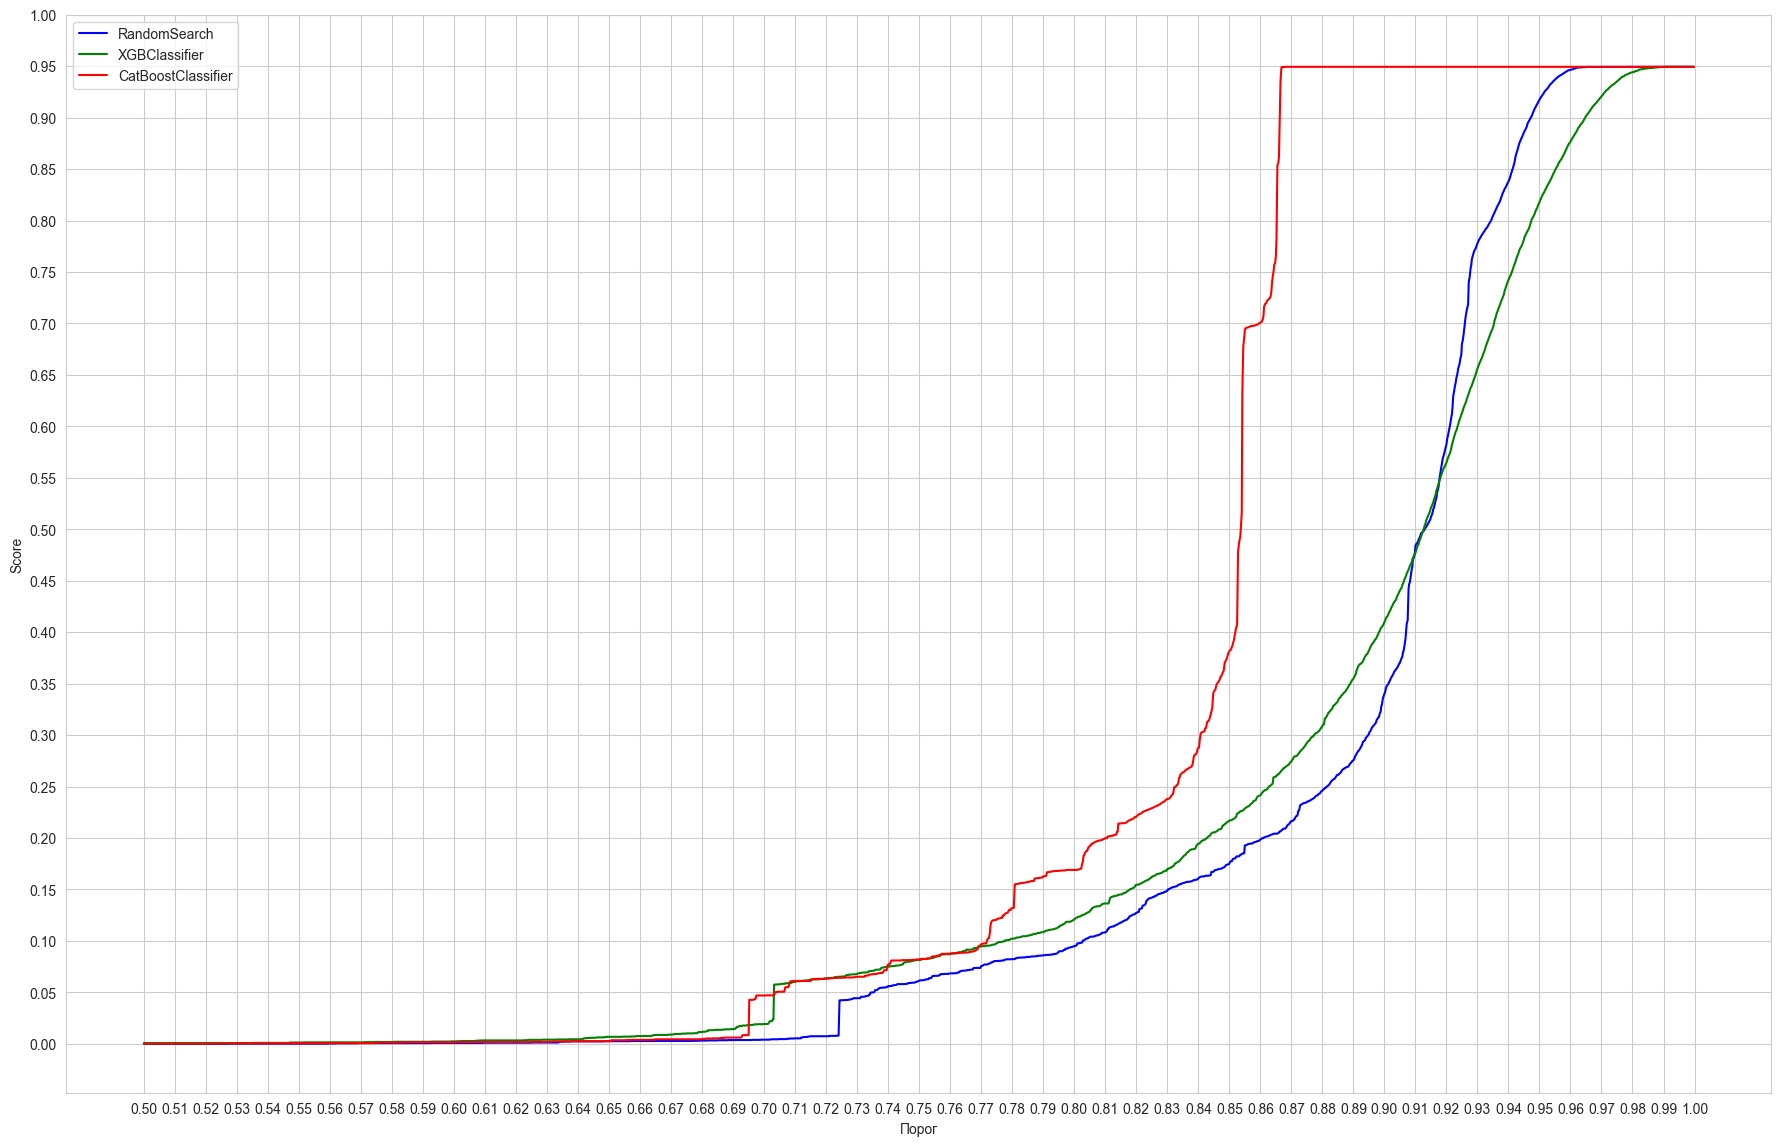

In [755]:
proba_threshold = [round(i, 4) for i in np.linspace(0.5, 1, num=2000, endpoint=False)]

# Создаем массивы порогов и результатов метрики f1
thresholds = []
rs_scores = []
xgbc_scores = []
catboost_scores = []

# Изменяем порог
for i in proba_threshold:
    predictions['rs_prediction'] = predictions['rs_proba'].apply(lambda x: 1 if x < i else 0)
    predictions['xgbc_prediction'] = predictions['xgbc_proba'].apply(lambda x: 1 if x < i else 0)
    predictions['catboost_prediction'] = predictions['catboost_proba'].apply(lambda x: 1 if x < i else 0)

    thresholds.append(i)

    rs_scores.append(f1_score(predictions['actual'], predictions['rs_prediction']))
    xgbc_scores.append(f1_score(predictions['actual'], predictions['xgbc_prediction']))
    catboost_scores.append(f1_score(predictions['actual'], predictions['catboost_prediction']))

fig, ax = plt.subplots(figsize=(22, 14))

sns.lineplot(x=thresholds, y=rs_scores,
             legend=True, label='RandomSearch',
             color='blue', ax=ax)
sns.lineplot(x=thresholds, y=xgbc_scores,
             label='XGBClassifier',
             color='green', ax=ax)
sns.lineplot(x=thresholds, y=catboost_scores,
             label='CatBoostClassifier',
             color='red', ax=ax)

ax.set_ylabel('Score')
ax.set_yticks(np.arange(0, 1.01, 0.05))

ax.set_xlabel('Порог')
ax.set_xticks(np.arange(0.5, 1.01, 0.01))

plt.show()
# plt.title('Зависимость потерь в млн рублей от выбранного порога');

In [756]:
# proba_threshold = [round(i, 4) for i in np.linspace(0.5, 1, num=2000, endpoint=False)]
#
# # Создаем массивы порогов и результатов метрики f1
# thresholds = []
# f1_scores = []
# precision_scores = []
# recall_scores = []
#
# # Изменяем порог
# for i in proba_threshold:
#     predictions['prediction'] = predictions['proba'].apply(lambda x: 1 if x < i else 0)
#
#     thresholds.append(i)
#
#     f1_scores.append(f1_score(predictions['actual'], predictions['prediction']))
#     precision_scores.append(precision_score(predictions['actual'], predictions['prediction']))
#     recall_scores.append(recall_score(predictions['actual'], predictions['prediction']))
#
# fig, ax = plt.subplots(figsize=(22, 14))
#
# sns.lineplot(x=thresholds, y=f1_scores,
#              legend=True, label='f1_score',
#              color='blue', ax=ax)
# sns.lineplot(x=thresholds, y=precision_scores,
#              label='precision_score',
#              color='green', ax=ax)
# sns.lineplot(x=thresholds, y=recall_scores,
#              label='recall_score',
#              color='red', ax=ax)
#
# ax.set_ylabel('Score')
# ax.set_yticks(np.arange(0, 1.01, 0.05))
#
# ax.set_xlabel('Порог')
# ax.set_xticks(np.arange(0.5, 1.01, 0.01))
#
# plt.show()
# # plt.title('Зависимость потерь в млн рублей от выбранного порога');

### Вывод:

После применения RandomizedSearchCV лучшей моделью оказалась `XGBClassifier`, со следующими параметрами:
- `preprocessor__num`: 'passthrough',
- `subsample`: 0.8,
- `reg_lambda`: 1,
- `reg_alpha`: 0.1,
- `n_estimators`: 200,
- `max_depth`: 6,
- `learning_rate`: 0.01,
- `colsample_bytree`: 0.8,

Точность метрики `f1_score` составила `0.951` на тренировочной и валидационной выборках. Метрика отличается на 0.0001, что говорит о том, что модель хорошо обучилась

## Анализ важности признаков

In [757]:
# Получаем обученную модель из OptunaSearchCV
best_model = catboost_optuna_cv.best_estimator_

# Создаем объяснитель SHAP для модели CatBoost
explainer = shap.TreeExplainer(best_model)

# Вычисляем SHAP-значения для тренировочных данных
shap_values = explainer(X_train)

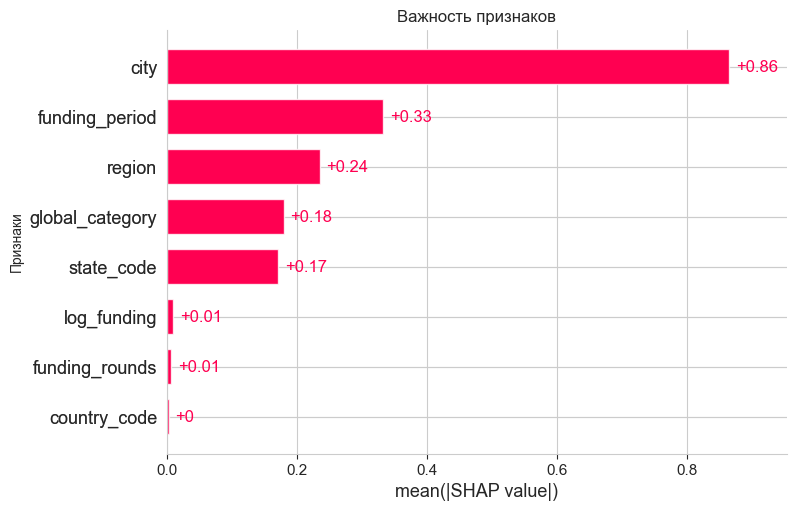

In [758]:
# Выводим график важности признаков
shap.plots.bar(shap_values, max_display=10, show=False)
fig, ax = plt.gcf(), plt.gca()

ax.set_ylabel('Признаки')
ax.set_title('Важность признаков')
plt.show()

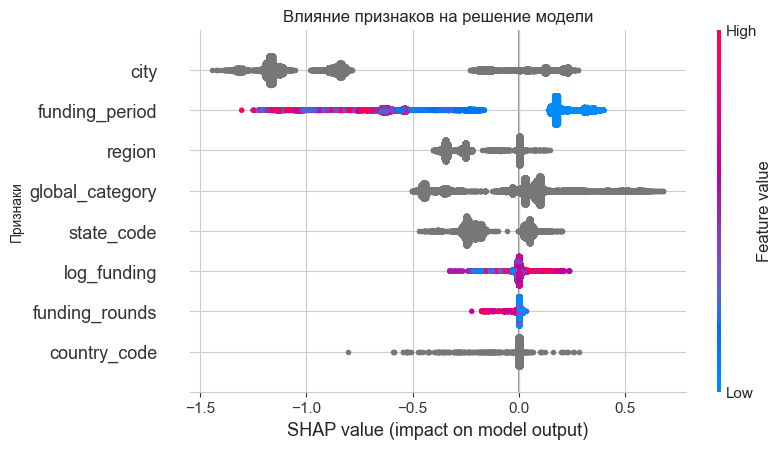

In [759]:
shap.plots.beeswarm(shap_values, max_display=15, show=False)
fig, ax = plt.gcf(), plt.gca()

ax.set_ylabel('Признаки')
ax.set_title('Влияние признаков на решение модели')
plt.show()

## Предсказания модели

In [832]:
predictions

,actual,rs_proba,xgbc_proba,catboost_proba,rs_prediction,xgbc_prediction,catboost_prediction
0,1,0.929594,0.963897,0.854143,1,1,1
1,1,0.887460,0.891519,0.848568,1,1,1
2,1,0.927159,0.939788,0.854143,1,1,1
3,1,0.917970,0.916314,0.852726,1,1,1
4,1,0.922504,0.927032,0.854920,1,1,1
...,...,...,...,...,...,...,...
11874,1,0.956161,0.981657,0.866424,1,1,1
11875,1,0.944102,0.934975,0.866561,1,1,1
11876,1,0.950676,0.954968,0.866561,1,1,1
11877,1,0.899576,0.879695,0.854029,1,1,1


In [833]:
X_test = test_df_processed
X_test

,country_code,state_code,region,city,funding_rounds,funding_period,log_funding,global_category
0,NIC,17,Copenhagen,Copenhagen,1,0,14.851964,Travel
1,USA,TN,TN - Other,other,1,0,14.508658,Technology
2,LUX,3,Esch-sur-alzette,other,2,126,12.967481,Technology
3,USA,CA,San Diego,San Diego,4,1935,17.362250,Healthcare
4,CAN,ON,Ottawa,Ottawa,1,0,15.326233,Manufacturing
...,...,...,...,...,...,...,...,...
13120,USA,CA,SF Bay Area,Sunnyvale,1,0,10.239996,Finance
13121,USA,CA,SF Bay Area,Mountain View,1,0,14.508658,Technology
13122,USA,WA,Seattle,Seattle,3,1030,15.538277,hardware + software
13123,USA,NY,New York City,New York,2,38,11.918397,E-Commerce


In [834]:
# Проверка для колонки 'category_list'
train_categories = X_train['global_category'].unique()
test_categories = X_test['global_category'].unique()

new_categories = set(test_categories) - set(train_categories)
print(f"Новые категории в тесте: {new_categories}")

Новые категории в тесте: {'shared services', 'natural gas uses', 'lotteries', 'direct sales', 'clean technology it', 'genetic testing', 'humanitarian', 'water purification', 'brokers'}


In [835]:
set(X_valid.columns) - set(X_test.columns)

set()

In [836]:
set(X_test.columns) - set(X_valid.columns)

set()

In [837]:
X_test['global_category'] = X_test['global_category'].fillna(X_test['global_category'].mode()[0])
X_test

,country_code,state_code,region,city,funding_rounds,funding_period,log_funding,global_category
0,NIC,17,Copenhagen,Copenhagen,1,0,14.851964,Travel
1,USA,TN,TN - Other,other,1,0,14.508658,Technology
2,LUX,3,Esch-sur-alzette,other,2,126,12.967481,Technology
3,USA,CA,San Diego,San Diego,4,1935,17.362250,Healthcare
4,CAN,ON,Ottawa,Ottawa,1,0,15.326233,Manufacturing
...,...,...,...,...,...,...,...,...
13120,USA,CA,SF Bay Area,Sunnyvale,1,0,10.239996,Finance
13121,USA,CA,SF Bay Area,Mountain View,1,0,14.508658,Technology
13122,USA,WA,Seattle,Seattle,3,1030,15.538277,hardware + software
13123,USA,NY,New York City,New York,2,38,11.918397,E-Commerce


In [838]:
submission = pd.DataFrame({
    'name': test_df['name'],
    'proba': catboost_optuna_cv.best_estimator_.predict_proba(X_test)[:, 1],
})

submission

,name,proba
0,Crystalsol,0.864625
1,JBI Fish & Wings,0.854143
2,COINPLUS,0.854632
3,Imagine Communications,0.865977
4,DNA13,0.854029
...,...,...
13120,Jymob,0.840419
13121,GlobaTrek,0.839650
13122,Inkd.com,0.866328
13123,AdWill,0.853569


In [839]:
# Проверка для колонки 'category_list'
train_categories = X_train['country_code'].unique()
test_categories = X_test['country_code'].unique()

new_categories = set(test_categories) - set(train_categories)
print(f"Новые категории в тесте: {new_categories}")

Новые категории в тесте: {'CMR', 'other', 'PSE'}


In [840]:
submission['status'] = submission['proba'].apply(lambda x: 'operating' if x > 0.854 else 'closed')
submission = submission[['name', 'status']]
submission

,name,status
0,Crystalsol,operating
1,JBI Fish & Wings,operating
2,COINPLUS,operating
3,Imagine Communications,operating
4,DNA13,operating
...,...,...
13120,Jymob,closed
13121,GlobaTrek,closed
13122,Inkd.com,operating
13123,AdWill,closed
